# General

# Step 0: Importing Packages

In [1]:
#we import all at the beginning so it's easier to see which packages are used by this notebook

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime as dt

#import auxiliar functions
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(os.path.dirname(currentdir))
sys.path.insert(1, parentdir)
from utils.helper_functions import *

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import category_encoders as ce
import joblib

#sklearn functions
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipe
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn import preprocessing
from imblearn.over_sampling import SMOTENC, SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import sklearn.feature_selection as fs
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score as cvs
from sklearn.metrics import confusion_matrix

# imports
import sklearn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR 
from sklearn import preprocessing
from sklearn.metrics import  r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import category_encoders as ce
import sklearn
import pickle
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, ExtraTreeRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, roc_auc_score
import joblib

from mlens.ensemble import SuperLearner
from mlens.metrics.metrics import rmse
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

[MLENS] backend: threading


In [2]:
# paths

#data_path = './cml2-length-of-stay-prediction-with-decision-trees/'
SEED = 4

# Step 1: Reading Data and Some Exploration

In [3]:
main_path = "C:/Users/sssalas/OneDrive - Philippine Competition Commission/Desktop/ML In-class/cml2-length-of-stay-prediction-with-decision-trees/"

# reading the main data
df = pd.read_csv(main_path + "mimic_train.csv")
df_orig = df.copy()

df_test = pd.read_csv(main_path+ "mimic_test_los.csv")
df_test_orig = df_test.copy()

#reading the comorbidity dataset
comorbidity = pd.read_csv(main_path + "extra_data/MIMIC_diagnoses.csv")
comorbidity_orig = comorbidity.copy()

In [4]:
df.head()

HOSPITAL_EXPIRE_FLAG  subject_id  hadm_id  icustay_id  HeartRate_Min  \
0                     0       55440   195768      228357           89.0   
1                     0       76908   126136      221004           63.0   
2                     0       95798   136645      296315           81.0   
3                     0       40708   102505      245557           76.0   
4                     0       28424   127337      225281            NaN   

   HeartRate_Max  HeartRate_Mean  SysBP_Min  SysBP_Max  SysBP_Mean  ...  \
0          145.0      121.043478       74.0      127.0  106.586957  ...   
1          110.0       79.117647       89.0      121.0  106.733333  ...   
2           98.0       91.689655       88.0      138.0  112.785714  ...   
3          128.0       98.857143       84.0      135.0  106.972973  ...   
4            NaN             NaN        NaN        NaN         NaN  ...   

          Diff  ADMISSION_TYPE  INSURANCE           RELIGION  MARITAL_STATUS  \
0 -61961.78470       EMERGENCY   Medicare  PROTESTANT QUAKER          SINGLE   
1 -43146.18378       EMERGENCY    Private       UNOBTAINABLE         MARRIED   
2 -42009.96157       EMERGENCY   Medicare  PROTESTANT QUAKER       SEPARATED   
3 -43585.37922        ELECTIVE   Medicare      NOT SPECIFIED         WIDOWED   
4 -50271.76602       EMERGENCY   Medicare             JEWISH         WIDOWED   

                ETHNICITY                  DIAGNOSIS  ICD9_diagnosis  \
0                   WHITE     GASTROINTESTINAL BLEED            5789   
1                   WHITE  ESOPHAGEAL FOOD IMPACTION           53013   
2  BLACK/AFRICAN AMERICAN             UPPER GI BLEED           56983   
3                   WHITE          HIATAL HERNIA/SDA            5533   
4                   WHITE             ABDOMINAL PAIN           56211   

   FIRST_CAREUNIT     LOS  
0            MICU  4.5761  
1            MICU  0.7582  
2            MICU  3.7626  
3            SICU  3.8734  
4           TSICU  5.8654  

[5 rows x 41 columns]

In [5]:
df.columns

Index(['HOSPITAL_EXPIRE_FLAG', 'subject_id', 'hadm_id', 'icustay_id',
       'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER', 'DOB', 'ADMITTIME', 'Diff', 'ADMISSION_TYPE',
       'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS',
       'ICD9_diagnosis', 'FIRST_CAREUNIT', 'LOS'],
      dtype='object')

In [6]:
df.describe()

HOSPITAL_EXPIRE_FLAG    subject_id        hadm_id     icustay_id  \
count          20885.000000  20885.000000   20885.000000   20885.000000   
mean               0.112282  58950.496098  150082.402298  250202.495523   
std                0.315720  25299.439535   28898.479845   28909.806302   
min                0.000000     23.000000  100001.000000  200001.000000   
25%                0.000000  41132.000000  125157.000000  225153.000000   
50%                0.000000  60441.000000  150152.000000  250452.000000   
75%                0.000000  80286.000000  175017.000000  275303.000000   
max                1.000000  99999.000000  199999.000000  299998.000000   

       HeartRate_Min  HeartRate_Max  HeartRate_Mean     SysBP_Min  \
count   18698.000000   18698.000000    18698.000000  18677.000000   
mean       69.705904     105.239801       85.180250     91.110564   
std        14.869840      20.922613       15.318208     17.532534   
min         2.000000      39.000000       34.714286      5.000000   
25%        60.000000      90.000000       74.272727     81.000000   
50%        69.000000     103.000000       84.131183     90.000000   
75%        79.000000     118.000000       95.185588    101.000000   
max       141.000000     280.000000      163.875000    181.000000   

          SysBP_Max    SysBP_Mean  ...     TempC_Max    TempC_Mean  \
count  18677.000000  18677.000000  ...  18388.000000  18388.000000   
mean     150.725920    119.145423  ...     37.428781     36.751717   
std       23.833793     16.701503  ...      0.799897      0.603476   
min       46.000000     46.000000  ...     30.800000     30.666667   
25%      134.000000    107.100000  ...     36.944444     36.388889   
50%      148.000000    116.901961  ...     37.333333     36.731481   
75%      164.000000    129.465116  ...     37.888889     37.092593   
max      323.000000    202.172414  ...     42.000000     40.238333   

           SpO2_Min      SpO2_Max     SpO2_Mean   Glucose_Min   Glucose_Max  \
count  18682.000000  18682.000000  18682.000000  20632.000000  20632.000000   
mean      91.007494     99.555883     96.866685    106.781975    182.129604   
std        7.399390      1.159792      2.333108     35.178811     92.665603   
min        1.000000     57.000000     47.666667      2.000000     42.000000   
25%       90.000000    100.000000     95.812500     86.000000    126.000000   
50%       92.000000    100.000000     97.142857    102.000000    161.000000   
75%       94.000000    100.000000     98.346154    121.000000    206.000000   
max      100.000000    100.000000    100.000000    563.000000   2440.000000   

       Glucose_Mean          Diff           LOS  
count  20632.000000  20885.000000  20885.000000  
mean     138.856428 -51617.069830      3.701046  
std       44.933145  10686.395846      5.175721  
min       42.000000 -72740.274440      0.056600  
25%      110.750000 -60864.454110      1.165400  
50%      128.666667 -51561.703460      2.020800  
75%      154.578571 -42327.560030      3.915800  
max      771.900000 -32157.494580    101.739000  

[8 rows x 30 columns]

In [7]:
df.dtypes

HOSPITAL_EXPIRE_FLAG      int64
subject_id                int64
hadm_id                   int64
icustay_id                int64
HeartRate_Min           float64
HeartRate_Max           float64
HeartRate_Mean          float64
SysBP_Min               float64
SysBP_Max               float64
SysBP_Mean              float64
DiasBP_Min              float64
DiasBP_Max              float64
DiasBP_Mean             float64
MeanBP_Min              float64
MeanBP_Max              float64
MeanBP_Mean             float64
RespRate_Min            float64
RespRate_Max            float64
RespRate_Mean           float64
TempC_Min               float64
TempC_Max               float64
TempC_Mean              float64
SpO2_Min                float64
SpO2_Max                float64
SpO2_Mean               float64
Glucose_Min             float64
Glucose_Max             float64
Glucose_Mean            float64
GENDER                   object
DOB                      object
ADMITTIME                object
Diff    

In [8]:
df.shape

(20885, 41)

In [9]:
df.isnull().sum()

HOSPITAL_EXPIRE_FLAG       0
subject_id                 0
hadm_id                    0
icustay_id                 0
HeartRate_Min           2187
HeartRate_Max           2187
HeartRate_Mean          2187
SysBP_Min               2208
SysBP_Max               2208
SysBP_Mean              2208
DiasBP_Min              2209
DiasBP_Max              2209
DiasBP_Mean             2209
MeanBP_Min              2186
MeanBP_Max              2186
MeanBP_Mean             2186
RespRate_Min            2189
RespRate_Max            2189
RespRate_Mean           2189
TempC_Min               2497
TempC_Max               2497
TempC_Mean              2497
SpO2_Min                2203
SpO2_Max                2203
SpO2_Mean               2203
Glucose_Min              253
Glucose_Max              253
Glucose_Mean             253
GENDER                     0
DOB                        0
ADMITTIME                  0
Diff                       0
ADMISSION_TYPE             0
INSURANCE                  0
RELIGION      

In [10]:
df_test.head()

#df_train has 5 columns more than the df_test

subject_id  hadm_id  icustay_id  HeartRate_Min  HeartRate_Max  \
0       64058   146725      208169           58.0           90.0   
1       55871   108789      251754           91.0          145.0   
2       42892   139885      242171          106.0          132.0   
3       66629   173017      263035           72.0          105.0   
4       79851   171573      279388           85.0          124.0   

   HeartRate_Mean  SysBP_Min  SysBP_Max  SysBP_Mean  DiasBP_Min  ...  \
0       85.244898       77.0      153.0   98.490909        40.0  ...   
1      115.055556       73.0      143.0  101.210526        42.0  ...   
2      117.750000       93.0      137.0  116.222222        51.0  ...   
3       83.627119       72.0      168.0  126.981818        39.0  ...   
4       98.600000       86.0      144.0  110.666667        52.0  ...   

             ADMITTIME         Diff  ADMISSION_TYPE  INSURANCE       RELIGION  \
0  2196-02-23 11:45:00 -67454.42740        ELECTIVE   Medicare       CATHOLIC   
1  2103-10-22 23:58:00 -34204.08546       EMERGENCY    Private  NOT SPECIFIED   
2  2115-06-28 07:15:00 -38710.61714        ELECTIVE   Medicare       CATHOLIC   
3  2162-08-01 21:00:00 -54902.54313       EMERGENCY    Private   EPISCOPALIAN   
4  2103-01-16 22:05:00 -33906.93488       EMERGENCY   Medicare       CATHOLIC   

   MARITAL_STATUS  ETHNICITY  \
0         MARRIED      WHITE   
1         MARRIED      WHITE   
2         MARRIED      WHITE   
3         WIDOWED      WHITE   
4          SINGLE      WHITE   

                                           DIAGNOSIS  ICD9_diagnosis  \
0  AORTIC STENOSIS\CORONARY ARTERY BYPASS GRAFT W...            4241   
1                                      HYPERGLYCEMIA           25013   
2                                  KIDNEY STONES/SDA            5920   
3                               RIGHT FEMUR FRACTURE           82120   
4                         PNEUMONIA;RAPID AF;HYPOXIA           51884   

   FIRST_CAREUNIT  
0            CSRU  
1            MICU  
2            MICU  
3             CCU  
4            MICU  

[5 rows x 39 columns]

In [11]:
# Correlation heatmap with pandas dataframes
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None)

# as expected, the vital statistics min, max, and mean are highly correlated. 
#but there is also some correlation across vital statistics e.g.SysBP and DiasBP

# Step 2 Data Cleaning

First, lest check if the columns of the test and train dataset are different.

In [12]:
print(df.columns)
print(df_test.columns)

df_cols = df.columns
df_test_cols = df_test.columns
difference = list(set(df_cols) - set(df_test_cols))
print(difference)

Index(['HOSPITAL_EXPIRE_FLAG', 'subject_id', 'hadm_id', 'icustay_id',
       'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER', 'DOB', 'ADMITTIME', 'Diff', 'ADMISSION_TYPE',
       'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS',
       'ICD9_diagnosis', 'FIRST_CAREUNIT', 'LOS'],
      dtype='object')
Index(['subject_id', 'hadm_id', 'icustay_id', 'HeartRate_Min', 'HeartRate_Max',
       'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC

In [13]:
y_train = df[['LOS']]
y_train = y_train
#df = df.drop(['LOS'], axis=1)

#same number of columns except label
print(df.shape)
print(df_test.shape)

(20885, 41)
(5221, 39)


<AxesSubplot:xlabel='LOS', ylabel='Density'>

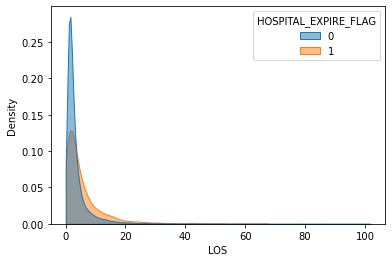

In [14]:
sns.kdeplot(data=df_orig, x="LOS", hue="HOSPITAL_EXPIRE_FLAG", cut=0, fill=True, common_norm=False, alpha=0.5)
#those who didn't die have LOS closer to 0

### Creating Age Column

We observe that there are columns that deals with time, namely DOB (date of birth) and ADMITTIME (time of admission). We could use these columns to calculate age of patient. 

We add the Diff column as the true dates have been masked to protect the identity of the patient. Then we calculate the age at time of admission as the difference between ADMITTIME and DOB. This variable is imprtant as older patients are more likely to die.

For patients over age 89, they shifted the date of birth by 300 years. We need to adjust for this accordingly. It is also important to note that we don't have a way of knowing the exact age of patients older than 89 years old.

In [15]:
for my_df in [df, df_test]:
# Convert admittime to date, adding "Diff" to make the dates realistic
    my_df['ADMITTIME'] = (pd.to_datetime(my_df['ADMITTIME']) + my_df["Diff"].apply(lambda x: dt.timedelta(x))).apply(lambda x: x.date())
# Convert dob to date, adding "Diff" to make the dates realistic
    my_df['DOB'] = (pd.to_datetime(my_df['DOB']) + my_df["Diff"].apply(lambda x: dt.timedelta(x))).apply(lambda x: x.date())
# Convert to age in years
    my_df['age'] = my_df.apply(lambda e: (e['ADMITTIME'] - e['DOB']).days/365, axis=1)

In [16]:
column = df['age']
max_value = column.max()
print(max_value)

column = df_test['age']
max_value = column.max()
print(max_value)

310.37808219178083
310.4876712328767


For patients who are older than 89 years old, we impute the values to be 90 years old. https://github.com/MIT-LCP/mimic-code/issues/637

In [17]:
df['age'] = df.age.where(df['age']<89, None)
df['age'] = df['age'].fillna(90)
column = df['age']
max_value = column.max()
print(max_value)

#doing the same for test set
df_test['age'] = df_test.age.where(df_test['age']<89, None)
df_test['age'] = df_test['age'].fillna(90)
column = df_test['age']
max_value = column.max()
print(max_value)

90.0
90.0


<AxesSubplot:xlabel='age', ylabel='Density'>

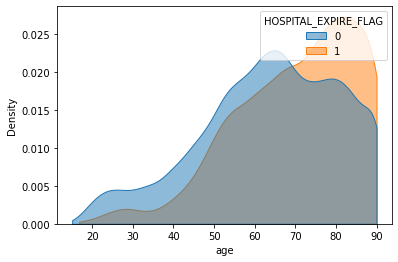

In [18]:
sns.kdeplot(data=df, x="age", hue="HOSPITAL_EXPIRE_FLAG", cut=0, fill=True, common_norm=False, alpha=0.5)
#older patients are more likely to die

## Data Wrangling on Commorbidity Dataset

We look at how we could incorporate the extra comorbidity dataset.

In [19]:
print(comorbidity.shape)
#we see that one the data is entered in a different format 
#multiple rows corresponding to one patient

comorbidity.head()

(651047, 4)


SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE
0         256   108811      1.0     53240
1         256   108811      2.0     41071
2         256   108811      3.0     53560
3         256   108811      4.0     40390
4         256   108811      5.0      5859

### Total Number of Prior Hospital Admissions

As mentioned previously, some patients have been admitted to the hospital several times. This may be indicative that the patient's illness/es is/are so grave that they have to go to be rushed back to the hospital multiple times. These same patients have a higher risk of dying. 

To extract this data, we count the number of "hadm_id" each subject has. We group by subject_id and hadm_id, and then do a cumulative count within groups.

In [20]:
print(len(df["subject_id"].unique()))
print(len(df["hadm_id"].unique()))

#frequency of visits to ICU
#cumcount counts the number of times the patient has been to the hospital at the time of visit
df['repeat_admissions'] = df.groupby(['hadm_id']).cumcount()
df_test['repeat_admissions'] = df_test.groupby(['hadm_id']).cumcount()

#same number of columns except label
print(df.shape)
print(df_test.shape)
df.head()

16317
19749
(20885, 43)
(5221, 41)


HOSPITAL_EXPIRE_FLAG  subject_id  hadm_id  icustay_id  HeartRate_Min  \
0                     0       55440   195768      228357           89.0   
1                     0       76908   126136      221004           63.0   
2                     0       95798   136645      296315           81.0   
3                     0       40708   102505      245557           76.0   
4                     0       28424   127337      225281            NaN   

   HeartRate_Max  HeartRate_Mean  SysBP_Min  SysBP_Max  SysBP_Mean  ...  \
0          145.0      121.043478       74.0      127.0  106.586957  ...   
1          110.0       79.117647       89.0      121.0  106.733333  ...   
2           98.0       91.689655       88.0      138.0  112.785714  ...   
3          128.0       98.857143       84.0      135.0  106.972973  ...   
4            NaN             NaN        NaN        NaN         NaN  ...   

   INSURANCE           RELIGION  MARITAL_STATUS               ETHNICITY  \
0   Medicare  PROTESTANT QUAKER          SINGLE                   WHITE   
1    Private       UNOBTAINABLE         MARRIED                   WHITE   
2   Medicare  PROTESTANT QUAKER       SEPARATED  BLACK/AFRICAN AMERICAN   
3   Medicare      NOT SPECIFIED         WIDOWED                   WHITE   
4   Medicare             JEWISH         WIDOWED                   WHITE   

                   DIAGNOSIS  ICD9_diagnosis  FIRST_CAREUNIT     LOS  \
0     GASTROINTESTINAL BLEED            5789            MICU  4.5761   
1  ESOPHAGEAL FOOD IMPACTION           53013            MICU  0.7582   
2             UPPER GI BLEED           56983            MICU  3.7626   
3          HIATAL HERNIA/SDA            5533            SICU  3.8734   
4             ABDOMINAL PAIN           56211           TSICU  5.8654   

         age  repeat_admissions  
0  69.608219                  0  
1  42.104110                  0  
2  68.210959                  0  
3  74.961644                  0  
4  79.424658                  0  

[5 rows x 43 columns]

### Number of Diagnoses per Visit

We observe that for each patient, there are different diagnosis and number of diagnoses. This information is available from the comorbidity dataset. Those who have more kinds of illnesses are more likely to die.

The variable "SEQ NUM" tells us the number of diagnoses per visit. From the comorbidities dataset, we can extract a count of diagnoses per visit by getting the maximum SEQ_NUM. 

In [21]:
#DIAGNOSES - count diagnoses by patient per hospital visit

# SEQ_NUM counts the diagnosis that each patient has per hospital admission
# the maximum SEQ_NUM is the total number of comorboidities that a patient has
comorbidity.columns = ['subject_id', 'hadm_id', 'SEQ_NUM', 'ICD9_diagnosis']
comorbidity_per_visit = comorbidity[['hadm_id', 'SEQ_NUM']].groupby(['hadm_id'], sort = False).max()

print(comorbidity_per_visit.shape)
comorbidity_per_visit.head()

(58976, 1)


SEQ_NUM
hadm_id         
108811      11.0
153771       9.0
155415       6.0
188869      14.0
102509       4.0

In [22]:
# Merge into the main main dataframe based on hospital admission
# Hospital admission is the unique identifier that we have since a patient could be included in 
# the main dataframe multiple times if she has been admitted repeatedly
df = df.merge(comorbidity_per_visit, on = ['hadm_id'], how = 'left')
df_test = df_test.merge(comorbidity_per_visit, on = ['hadm_id'], how = 'left')

#same number of columns except label
print(df.shape)
print(df_test.shape)
df.head()

(20885, 44)
(5221, 42)


HOSPITAL_EXPIRE_FLAG  subject_id  hadm_id  icustay_id  HeartRate_Min  \
0                     0       55440   195768      228357           89.0   
1                     0       76908   126136      221004           63.0   
2                     0       95798   136645      296315           81.0   
3                     0       40708   102505      245557           76.0   
4                     0       28424   127337      225281            NaN   

   HeartRate_Max  HeartRate_Mean  SysBP_Min  SysBP_Max  SysBP_Mean  ...  \
0          145.0      121.043478       74.0      127.0  106.586957  ...   
1          110.0       79.117647       89.0      121.0  106.733333  ...   
2           98.0       91.689655       88.0      138.0  112.785714  ...   
3          128.0       98.857143       84.0      135.0  106.972973  ...   
4            NaN             NaN        NaN        NaN         NaN  ...   

            RELIGION  MARITAL_STATUS               ETHNICITY  \
0  PROTESTANT QUAKER          SINGLE                   WHITE   
1       UNOBTAINABLE         MARRIED                   WHITE   
2  PROTESTANT QUAKER       SEPARATED  BLACK/AFRICAN AMERICAN   
3      NOT SPECIFIED         WIDOWED                   WHITE   
4             JEWISH         WIDOWED                   WHITE   

                   DIAGNOSIS  ICD9_diagnosis  FIRST_CAREUNIT     LOS  \
0     GASTROINTESTINAL BLEED            5789            MICU  4.5761   
1  ESOPHAGEAL FOOD IMPACTION           53013            MICU  0.7582   
2             UPPER GI BLEED           56983            MICU  3.7626   
3          HIATAL HERNIA/SDA            5533            SICU  3.8734   
4             ABDOMINAL PAIN           56211           TSICU  5.8654   

         age  repeat_admissions  SEQ_NUM  
0  69.608219                  0     17.0  
1  42.104110                  0      3.0  
2  68.210959                  0     14.0  
3  74.961644                  0     15.0  
4  79.424658                  0     16.0  

[5 rows x 44 columns]

### ICD9 Codes

As we will see later, there are around 6000 unique diagnoses. We cannot just encode these categories as is. We partly solve this problem later on by using Binary Enocder instead so I could choose the number of columns that would represent some the unique categories.

However, in addition to the step above, it would be valuable to get which illnesses are more deadly. Per type of diagnosis, we get the average length of stay of patients for a given diagnosis. This is intuitive require longre hospitalization than others.

Instead of encoding all how deadly all the diseases are for each patient, we only get the that is associated with longest LOS diagnosis, the median, and the mean (relative to the diagnosis of this patient), as well as the sum of the the average LOS given all dieases a patient has. The average for each ICD9_diagnosis is the total LOS associated with a given diseases for a certain diagnosis divided by the total count of the same diagnosis.

In [23]:
# We create a new dataframe that combines the comorbidity dataframe and whether the subject has died or not
data_diagnoses_all = comorbidity.merge(df[['hadm_id', 'LOS']], on = ['hadm_id'], how = 'left')
data_diagnoses_all.head()

from category_encoders import TargetEncoder

In [24]:
encoder = TargetEncoder(smoothing = 1.0)
data_diagnoses_all['ICD9_diagnosis'] = encoder.fit_transform(data_diagnoses_all['ICD9_diagnosis'], data_diagnoses_all['LOS'])

#it is okay to do encoding as a whole because we are looking at how deadly the diseases are relative to the whole population

In [25]:
data_diagnoses_all.head()

subject_id  hadm_id  SEQ_NUM  ICD9_diagnosis     LOS
0         256   108811      1.0        4.263924  1.7219
1         256   108811      2.0        4.499102  1.7219
2         256   108811      3.0        2.736041  1.7219
3         256   108811      4.0        3.857329  1.7219
4         256   108811      5.0        3.895319  1.7219

In [26]:
# Merge death rates in with comorbidities data

# We call it death rates even tho we do not target using the HOSPITAL_EXPIRE_FLAG anymore
# We now target with the LOS, so technically what we are getting are the average length of stay (LOS) for each kind of diagnosis


# Max, mean and median death rates per patient 
data_death_rates = data_diagnoses_all.groupby(['hadm_id']).agg(max_los = pd.NamedAgg('ICD9_diagnosis', 'max'),
                                                               mean_los = pd.NamedAgg('ICD9_diagnosis', 'mean'),
                                                               median_los = pd.NamedAgg('ICD9_diagnosis', 'median'),
                                                              sum_los = pd.NamedAgg('ICD9_diagnosis', 'sum'))

# Merge into main data
df = df.merge(data_death_rates, on = ['hadm_id'], how = 'left')
df_test = df_test.merge(data_death_rates, on = ['hadm_id'], how = 'left')

#same number of columns except label
print(df.shape)
print(df_test.shape)
df.head()

(20885, 48)
(5221, 46)


HOSPITAL_EXPIRE_FLAG  subject_id  hadm_id  icustay_id  HeartRate_Min  \
0                     0       55440   195768      228357           89.0   
1                     0       76908   126136      221004           63.0   
2                     0       95798   136645      296315           81.0   
3                     0       40708   102505      245557           76.0   
4                     0       28424   127337      225281            NaN   

   HeartRate_Max  HeartRate_Mean  SysBP_Min  SysBP_Max  SysBP_Mean  ...  \
0          145.0      121.043478       74.0      127.0  106.586957  ...   
1          110.0       79.117647       89.0      121.0  106.733333  ...   
2           98.0       91.689655       88.0      138.0  112.785714  ...   
3          128.0       98.857143       84.0      135.0  106.972973  ...   
4            NaN             NaN        NaN        NaN         NaN  ...   

   ICD9_diagnosis  FIRST_CAREUNIT     LOS        age  repeat_admissions  \
0            5789            MICU  4.5761  69.608219                  0   
1           53013            MICU  0.7582  42.104110                  0   
2           56983            MICU  3.7626  68.210959                  0   
3            5533            SICU  3.8734  74.961644                  0   
4           56211           TSICU  5.8654  79.424658                  0   

   SEQ_NUM    max_los  mean_los  median_los     sum_los  
0     17.0   7.381652  4.339440    4.201232   73.770483  
1      3.0   6.641739  3.115149    1.532329    9.345447  
2     14.0   8.659720  5.023597    4.322307   70.330355  
3     15.0   9.706866  4.028846    3.493876   60.432695  
4     16.0  10.790989  5.711405    5.094307  182.764946  

[5 rows x 48 columns]

### Dropping some columns

In [27]:
#drop variables not known on the first day, variable id's, and duplicate columns
to_drop = ['hadm_id', 'icustay_id', 'DOB', 'ADMITTIME', 'Diff']
df = df.drop(to_drop,axis=1)
df_test = df_test.drop(to_drop,axis=1)
print(df.shape)
print(df_test.shape)

(20885, 43)
(5221, 41)


In [28]:
df_cols = df.columns
df_test_cols = df_test.columns

difference = list(set(df_cols) - set(df_test_cols))
print(difference)

['LOS', 'HOSPITAL_EXPIRE_FLAG']


In [29]:
df_test.columns

Index(['subject_id', 'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean',
       'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max',
       'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'GENDER',
       'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis', 'FIRST_CAREUNIT', 'age',
       'repeat_admissions', 'SEQ_NUM', 'max_los', 'mean_los', 'median_los',
       'sum_los'],
      dtype='object')

## Feature Engineering

### Handling Missing Values

In [30]:
#counting the rows with missing values
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]
print(rows_with_NaN.shape)

is_NaN = df_test.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df_test[row_has_NaN]
print(rows_with_NaN.shape)

(3409, 43)
(858, 41)


At first, I thought the the data were missing at random. However, looking at the dataframe, those who have missing value in one column are oftentimes the same people with missing values for other column.
Therefore, I am more inclined to identify this missingness as structural.
The data is missing for an apparent and/or logical reason, with easily inferred mechanism (unlike missing not at random)

What I will do is impute values based on nearest neighbors, and do back-fill, forward-fill.

In [31]:
df.columns[df.isnull().any()]

#Most of the missing values has to do with vital statistics. 

Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'MARITAL_STATUS'],
      dtype='object')

In [32]:
df["MARITAL_STATUS"].unique()

array(['SINGLE', 'MARRIED', 'SEPARATED', 'WIDOWED', 'DIVORCED', nan,
       'UNKNOWN (DEFAULT)', 'LIFE PARTNER'], dtype=object)

In [33]:
#first we deal with marital status missing
# there is a category of unknown, so i'll fill the missing values with that category
df['MARITAL_STATUS'] = df['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
df_test['MARITAL_STATUS'] = df_test['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')

In [34]:
#converting the HOSPITAL_EXPIRE_FLAG to categorical variable
df['HOSPITAL_EXPIRE_FLAG'] = pd.Categorical(df.HOSPITAL_EXPIRE_FLAG)
df['HOSPITAL_EXPIRE_FLAG'] = df.HOSPITAL_EXPIRE_FLAG.cat.codes

In [35]:
#converting the categorical variables to categorical data type
for my_df in [df, df_test]:
    for col in ["GENDER", "INSURANCE", "MARITAL_STATUS", "FIRST_CAREUNIT", "ADMISSION_TYPE", "DIAGNOSIS", "ICD9_diagnosis"]:
        my_df[col] = my_df[col].astype('category')
        #my_df[col] = pd.factorize(my_df[col], sort=True)[0] + 1 

In [36]:
df.dtypes

HOSPITAL_EXPIRE_FLAG        int8
subject_id                 int64
HeartRate_Min            float64
HeartRate_Max            float64
HeartRate_Mean           float64
SysBP_Min                float64
SysBP_Max                float64
SysBP_Mean               float64
DiasBP_Min               float64
DiasBP_Max               float64
DiasBP_Mean              float64
MeanBP_Min               float64
MeanBP_Max               float64
MeanBP_Mean              float64
RespRate_Min             float64
RespRate_Max             float64
RespRate_Mean            float64
TempC_Min                float64
TempC_Max                float64
TempC_Mean               float64
SpO2_Min                 float64
SpO2_Max                 float64
SpO2_Mean                float64
Glucose_Min              float64
Glucose_Max              float64
Glucose_Mean             float64
GENDER                  category
ADMISSION_TYPE          category
INSURANCE               category
RELIGION                  object
MARITAL_ST

### Creating Dummies & Encoding

There are too many unique values for ethnicity and by theory, we cannot really say that a specific ethinicity is associated with longer LOS. But still we keep the aggregated version of ethnicity as it may still capture some important information.

In [37]:
df['ETHNICITY'].value_counts()

WHITE                                                       15112
BLACK/AFRICAN AMERICAN                                       1977
UNABLE TO OBTAIN                                              577
UNKNOWN/NOT SPECIFIED                                         568
HISPANIC OR LATINO                                            562
OTHER                                                         489
ASIAN                                                         265
PATIENT DECLINED TO ANSWER                                    175
HISPANIC/LATINO - PUERTO RICAN                                155
ASIAN - CHINESE                                               146
BLACK/CAPE VERDEAN                                            126
WHITE - RUSSIAN                                               117
BLACK/HAITIAN                                                  72
HISPANIC/LATINO - DOMINICAN                                    59
ASIAN - ASIAN INDIAN                                           58
MULTI RACE

In [38]:
df['ETHNICITY'] = df['ETHNICITY'].replace(['ASIAN', 'ASIAN - CHINESE', 'ASIAN - ASIAN INDIAN', 'ASIAN - VIETNAMESE', 'ASIAN - FILIPINO', 'ASIAN - CAMBODIAN',
                                                     'ASIAN - JAPANESE', 'ASIAN - THAI', 'ASIAN - OTHER', 'ASIAN - KOREAN'
                                                     ], 'ASIAN')

df['ETHNICITY'] = df['ETHNICITY'].replace(['HISPANIC 0R LATINO', 'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - DOMINICAN', 
                                                     'HISPANIC/LATINO - GUATEMALAN', 'HISPANIC/LATINO - CUBAN', 'HISPANIC/LATINO - SALVADORAN',
                                                     'HISPANIC/LATINO - MEXICAN', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)', 'HISPANIC/LATINO - COLOMBIAN',
                                                     'HISPANIC/LATINO - HONDURAN', 'SOUTH AMERICAN'
                                                     ], 'HISPANIC OR LATINO')

df['ETHNICITY'] = df['ETHNICITY'].replace(['WHITE', 'WHITE - RUSSIAN', 'WHITE - OTHER EUROPEAN', 'WHITE - EASTERN EUROPEAN',
                                                     'WHITE - BRAZILIAN'
                                                     ], 'WHITE')

df['ETHNICITY'] = df['ETHNICITY'].replace(['BLACK/AFRICAN', 'BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN', 'BLACK/HAITIAN'
                                                     ], 'BLACK')

df['ETHNICITY'] = df['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'UNKNOWN/NOT SPECIFIED', 'PATIENT DECLINED TO ANSWER'
                                                     ], 'UNKNOWN')

df['ETHNICITY'] = df['ETHNICITY'].replace(['AMERICAN INDIAN/ALASKA NATIVE', 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE', 
                                                     'CARIBBEAN ISLAND', 'MIDDLE EASTERN', 'OTHER', 'PORTUGUESE', 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 
                                                     'MULTI RACE ethnicity'
                                                     ], 'OTHER')

In [39]:
df_test['ETHNICITY'] = df_test['ETHNICITY'].replace(['ASIAN', 'ASIAN - CHINESE', 'ASIAN - ASIAN INDIAN', 'ASIAN - VIETNAMESE', 'ASIAN - FILIPINO', 'ASIAN - CAMBODIAN',
                                                     'ASIAN - JAPANESE', 'ASIAN - THAI', 'ASIAN - OTHER', 'ASIAN - KOREAN'
                                                     ], 'ASIAN')

df_test['ETHNICITY'] = df_test['ETHNICITY'].replace(['HISPANIC 0R LATINO', 'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - DOMINICAN', 
                                                     'HISPANIC/LATINO - GUATEMALAN', 'HISPANIC/LATINO - CUBAN', 'HISPANIC/LATINO - SALVADORAN',
                                                     'HISPANIC/LATINO - MEXICAN', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)', 'HISPANIC/LATINO - COLOMBIAN',
                                                     'HISPANIC/LATINO - HONDURAN', 'SOUTH AMERICAN'
                                                     ], 'HISPANIC OR LATINO')

df_test['ETHNICITY'] = df_test['ETHNICITY'].replace(['WHITE', 'WHITE - RUSSIAN', 'WHITE - OTHER EUROPEAN', 'WHITE - EASTERN EUROPEAN',
                                                     'WHITE - BRAZILIAN'
                                                     ], 'WHITE')

df_test['ETHNICITY'] = df_test['ETHNICITY'].replace(['BLACK/AFRICAN', 'BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN', 'BLACK/HAITIAN'
                                                     ], 'BLACK')

df_test['ETHNICITY'] = df_test['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'UNKNOWN/NOT SPECIFIED', 'PATIENT DECLINED TO ANSWER'
                                                     ], 'UNKNOWN')

df_test['ETHNICITY'] = df_test['ETHNICITY'].replace(['AMERICAN INDIAN/ALASKA NATIVE', 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE', 
                                                     'CARIBBEAN ISLAND', 'MIDDLE EASTERN', 'OTHER', 'PORTUGUESE', 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 
                                                     'MULTI RACE ethnicity'
                                                     ], 'OTHER')

In [40]:
df['ETHNICITY'].value_counts()

WHITE                   15330
BLACK                    2201
UNKNOWN                  1320
HISPANIC OR LATINO        859
OTHER                     580
ASIAN                     545
MULTI RACE ETHNICITY       50
Name: ETHNICITY, dtype: int64

In [41]:
df['RELIGION'].value_counts()

CATHOLIC                  7655
NOT SPECIFIED             5398
PROTESTANT QUAKER         2753
JEWISH                    1840
UNOBTAINABLE              1515
OTHER                      702
EPISCOPALIAN               288
GREEK ORTHODOX             178
CHRISTIAN SCIENTIST        164
BUDDHIST                   109
MUSLIM                      74
UNITARIAN-UNIVERSALIST      54
JEHOVAH'S WITNESS           45
ROMANIAN EAST. ORTH         41
HINDU                       38
7TH DAY ADVENTIST           30
HEBREW                       1
Name: RELIGION, dtype: int64

In [42]:
religion_other = ['HEBREW', 'UNITARIAN-UNIVERSALIST', 'HINDU', 'GREEK ORTHODOX',"JEHOVAH'S WITNESS", "BUDDHIST", 'MUSLIM', 'OTHER', 'CHRISTIAN SCIENTIST', 'EPISCOPALIAN', 'ROMANIAN EAST. ORTH', '7TH DAY ADVENTIST'] 
df['RELIGION'] = df['RELIGION'].replace(religion_other, 'OTHER')
df_test['RELIGION'] = df_test['RELIGION'].replace(religion_other, 'OTHER')

In [43]:
df['RELIGION'].value_counts()

CATHOLIC             7655
NOT SPECIFIED        5398
PROTESTANT QUAKER    2753
JEWISH               1840
OTHER                1724
UNOBTAINABLE         1515
Name: RELIGION, dtype: int64

In [44]:
cat_columns = ['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'FIRST_CAREUNIT', 'DIAGNOSIS', 'ICD9_diagnosis']
df_cat = df[cat_columns]

print(df_cat.nunique())

GENDER               2
ADMISSION_TYPE       3
INSURANCE            5
RELIGION             6
MARITAL_STATUS       7
ETHNICITY            7
FIRST_CAREUNIT       5
DIAGNOSIS         6193
ICD9_diagnosis    1853
dtype: int64


In [45]:
#separating labels and feautres
y = df['LOS']
X_train = df.drop(['LOS', 'HOSPITAL_EXPIRE_FLAG'], axis=1)


X_test = df_test

In [46]:
X_train.columns

Index(['subject_id', 'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean',
       'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max',
       'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'GENDER',
       'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis', 'FIRST_CAREUNIT', 'age',
       'repeat_admissions', 'SEQ_NUM', 'max_los', 'mean_los', 'median_los',
       'sum_los'],
      dtype='object')

In [47]:
#dropping DIAGNOSIS column as these have been already encoded beforehand
X_train = X_train.drop(['DIAGNOSIS', 'ICD9_diagnosis'], axis=1)
X_test = X_test.drop(['DIAGNOSIS', 'ICD9_diagnosis'], axis=1)

X_train_columns = X_train.columns
X_test_columns = X_test.columns

#for my_df in [X_train, X_test]:
#    for col in ["ICD9_diagnosis"]:
#        my_df[col] = my_df[col].astype('category')
#        my_df[col] = pd.factorize(my_df[col], sort=True)[0] + 1 

### Forward/Backward filling from previous visits
We can use subject id's to forward and backward fill missing data.

In [48]:
X_train = X_train.groupby(['subject_id'], as_index = False).apply(lambda group: group.ffill())
X_test = X_test.groupby(['subject_id'], as_index = False).apply(lambda group: group.ffill())

In [49]:
X_train = X_train.groupby(['subject_id'], as_index = False).apply(lambda group: group.bfill())
X_test = X_test.groupby(['subject_id'], as_index = False).apply(lambda group: group.bfill())

In [50]:
X_train = X_train.drop(['subject_id'], axis=1)
X_test = X_test.drop(['subject_id'], axis=1)

X_train.head()

HeartRate_Min  HeartRate_Max  HeartRate_Mean  SysBP_Min  SysBP_Max  \
0           89.0          145.0      121.043478       74.0      127.0   
1           63.0          110.0       79.117647       89.0      121.0   
2           81.0           98.0       91.689655       88.0      138.0   
3           76.0          128.0       98.857143       84.0      135.0   
4           58.0           64.0       60.324324       78.0      118.0   

   SysBP_Mean  DiasBP_Min  DiasBP_Max  DiasBP_Mean  MeanBP_Min  ...  \
0  106.586957        42.0        90.0    61.173913        59.0  ...   
1  106.733333        49.0        74.0    64.733333        58.0  ...   
2  112.785714        45.0        67.0    56.821429        64.0  ...   
3  106.972973        30.0        89.0    41.864865        48.0  ...   
4   99.428571        26.0        47.0    38.880952        39.0  ...   

   MARITAL_STATUS  ETHNICITY  FIRST_CAREUNIT        age  repeat_admissions  \
0          SINGLE      WHITE            MICU  69.608219                  0   
1         MARRIED      WHITE            MICU  42.104110                  0   
2       SEPARATED      BLACK            MICU  68.210959                  0   
3         WIDOWED      WHITE            SICU  74.961644                  0   
4         WIDOWED      WHITE           TSICU  79.424658                  0   

   SEQ_NUM    max_los  mean_los  median_los     sum_los  
0     17.0   7.381652  4.339440    4.201232   73.770483  
1      3.0   6.641739  3.115149    1.532329    9.345447  
2     14.0   8.659720  5.023597    4.322307   70.330355  
3     15.0   9.706866  4.028846    3.493876   60.432695  
4     16.0  10.790989  5.711405    5.094307  182.764946  

[5 rows x 38 columns]

In [51]:
X_train.columns

Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'FIRST_CAREUNIT', 'age',
       'repeat_admissions', 'SEQ_NUM', 'max_los', 'mean_los', 'median_los',
       'sum_los'],
      dtype='object')

In [52]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
#cat_encoder = TargetEncoder()

### Imputing

In [53]:
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

cont_imputer = KNNImputer(n_neighbors=100, weights="distance")
#cont_imputer = SimpleImputer(strategy="mean")

In [54]:
#counting the rows with missing values
is_NaN = X_train.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = X_train[row_has_NaN]
print(rows_with_NaN.shape)

is_NaN = X_test.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = X_test[row_has_NaN]
print(rows_with_NaN.shape)

(2237, 38)
(650, 38)


### Standardizing

In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

cont_scaler = RobustScaler()
cat_scaler = StandardScaler()

### Removing Outliers

Did not improve my model, so I commented it out.

In [56]:

# Update list of numerical and categorical features
num_feat = X_train.select_dtypes(exclude=['object', 'category']).columns
print(num_feat)

cat_feat = X_train.select_dtypes(include=['object', 'category']).columns
print(cat_feat)

# make own category for preprocessing 'ICD9_diagnosis'
#icd9_feat = X_train[['max_death_rate', 'mean_death_rate', 'median_death_rate', 'sum_death_rate']]
#print(icd9_feat)


Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'age', 'repeat_admissions', 'SEQ_NUM', 'max_los',
       'mean_los', 'median_los', 'sum_los'],
      dtype='object')
Index(['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'FIRST_CAREUNIT'],
      dtype='object')


In [57]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer


# pipeline for numerical data
num_preprocessing = Pipeline(steps=[
    ('cont_scaler', cont_scaler),
    ('cont_imputer', cont_imputer)   
])

# pipeline for categorical data
cat_preprocessing = Pipeline(steps=[
    #SimpleImputer(strategy="most_frequent"), # we only have missing data now in the continious 
    ('cat_encoder', cat_encoder),
    ('cat_scaler', cat_scaler)])

# combine preprocessing pipelines using a columnTransformer
preprocessing = ColumnTransformer(
    [("num", num_preprocessing, num_feat),
     ("cat", cat_preprocessing, cat_feat)#,
     ]
    #,remainder='passthrough'
    , remainder='drop'
)

In [58]:
from sklearn import set_config
set_config(display="diagram")
preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('cont_scaler',
                                                  RobustScaler()),
                                                 ('cont_imputer',
                                                  KNNImputer(n_neighbors=100,
                                                             weights='distance'))]),
                                 Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_...
       'Glucose_Mean', 'age', 'repeat_admissions', 'SEQ_NUM', 'max_los',
       'mean_los', 'median_los', 'sum_los'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('cat_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False)),
                                                 ('cat_scaler',
                                                  StandardScaler())]),
                                 Index(['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'FIRST_CAREUNIT'],
      dtype='object'))])

In [59]:
print(X_train.shape)
X_train.head()

(20885, 38)


HeartRate_Min  HeartRate_Max  HeartRate_Mean  SysBP_Min  SysBP_Max  \
0           89.0          145.0      121.043478       74.0      127.0   
1           63.0          110.0       79.117647       89.0      121.0   
2           81.0           98.0       91.689655       88.0      138.0   
3           76.0          128.0       98.857143       84.0      135.0   
4           58.0           64.0       60.324324       78.0      118.0   

   SysBP_Mean  DiasBP_Min  DiasBP_Max  DiasBP_Mean  MeanBP_Min  ...  \
0  106.586957        42.0        90.0    61.173913        59.0  ...   
1  106.733333        49.0        74.0    64.733333        58.0  ...   
2  112.785714        45.0        67.0    56.821429        64.0  ...   
3  106.972973        30.0        89.0    41.864865        48.0  ...   
4   99.428571        26.0        47.0    38.880952        39.0  ...   

   MARITAL_STATUS  ETHNICITY  FIRST_CAREUNIT        age  repeat_admissions  \
0          SINGLE      WHITE            MICU  69.608219                  0   
1         MARRIED      WHITE            MICU  42.104110                  0   
2       SEPARATED      BLACK            MICU  68.210959                  0   
3         WIDOWED      WHITE            SICU  74.961644                  0   
4         WIDOWED      WHITE           TSICU  79.424658                  0   

   SEQ_NUM    max_los  mean_los  median_los     sum_los  
0     17.0   7.381652  4.339440    4.201232   73.770483  
1      3.0   6.641739  3.115149    1.532329    9.345447  
2     14.0   8.659720  5.023597    4.322307   70.330355  
3     15.0   9.706866  4.028846    3.493876   60.432695  
4     16.0  10.790989  5.711405    5.094307  182.764946  

[5 rows x 38 columns]

In [60]:
preprocessing.fit(X_train)
X_train_pp = preprocessing.transform(X_train)
X_train_pp.shape
X_train_pp

array([[ 1.05263158,  1.5       ,  1.7635725 , ...,  1.19048115,
        -0.48378334, -0.38080305],
       [-0.31578947,  0.25      , -0.23973251, ...,  1.19048115,
        -0.48378334, -0.38080305],
       [ 0.63157895, -0.17857143,  0.36098466, ...,  1.19048115,
        -0.48378334, -0.38080305],
       ...,
       [-0.57894737, -0.21428571, -0.34410365, ...,  1.19048115,
        -0.48378334, -0.38080305],
       [-0.52631579, -0.03571429, -0.10944036, ..., -0.8399965 ,
        -0.48378334, -0.38080305],
       [-0.52631579, -0.21428571, -0.31576969, ...,  1.19048115,
        -0.48378334, -0.38080305]])

In [61]:
X_test_pp = preprocessing.transform(X_test)
print(X_test_pp.shape)
X_test_pp

(5221, 66)


array([[-0.57894737, -0.46428571,  0.05304051, ..., -0.8399965 ,
        -0.48378334, -0.38080305],
       [ 1.15789474,  1.5       ,  1.47745687, ...,  1.19048115,
        -0.48378334, -0.38080305],
       [ 1.94736842,  1.03571429,  1.60620313, ...,  1.19048115,
        -0.48378334, -0.38080305],
       ...,
       [ 0.26315789, -0.42857143, -0.12645425, ...,  1.19048115,
        -0.48378334, -0.38080305],
       [ 0.05263158, -0.5       , -0.18435549, ..., -0.8399965 ,
        -0.48378334, -0.38080305],
       [ 0.57894737,  0.        ,  0.3049111 , ..., -0.8399965 ,
        -0.48378334, -0.38080305]])

In [62]:
#just to get the feature names for model interpreation

clf = Pipeline(steps=[('preprocessor', preprocessing),
                      ('classifier', LinearRegression())])

clf.fit(X_train, y_train)

cat_column_names = clf.named_steps['preprocessor'].transformers_[1][1]\
   .named_steps['cat_encoder'].get_feature_names(cat_feat)

In [63]:
cat_column_names = list(cat_column_names)
cat_column_names

['GENDER_F',
 'GENDER_M',
 'ADMISSION_TYPE_ELECTIVE',
 'ADMISSION_TYPE_EMERGENCY',
 'ADMISSION_TYPE_URGENT',
 'INSURANCE_Government',
 'INSURANCE_Medicaid',
 'INSURANCE_Medicare',
 'INSURANCE_Private',
 'INSURANCE_Self Pay',
 'RELIGION_CATHOLIC',
 'RELIGION_JEWISH',
 'RELIGION_NOT SPECIFIED',
 'RELIGION_OTHER',
 'RELIGION_PROTESTANT QUAKER',
 'RELIGION_UNOBTAINABLE',
 'MARITAL_STATUS_DIVORCED',
 'MARITAL_STATUS_LIFE PARTNER',
 'MARITAL_STATUS_MARRIED',
 'MARITAL_STATUS_SEPARATED',
 'MARITAL_STATUS_SINGLE',
 'MARITAL_STATUS_UNKNOWN (DEFAULT)',
 'MARITAL_STATUS_WIDOWED',
 'ETHNICITY_ASIAN',
 'ETHNICITY_BLACK',
 'ETHNICITY_HISPANIC OR LATINO',
 'ETHNICITY_MULTI RACE ETHNICITY',
 'ETHNICITY_OTHER',
 'ETHNICITY_UNKNOWN',
 'ETHNICITY_WHITE',
 'FIRST_CAREUNIT_CCU',
 'FIRST_CAREUNIT_CSRU',
 'FIRST_CAREUNIT_MICU',
 'FIRST_CAREUNIT_SICU',
 'FIRST_CAREUNIT_TSICU']

In [64]:
X_train_columns 

Index(['subject_id', 'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean',
       'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max',
       'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'GENDER',
       'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'FIRST_CAREUNIT', 'age', 'repeat_admissions', 'SEQ_NUM',
       'max_los', 'mean_los', 'median_los', 'sum_los'],
      dtype='object')

In [65]:
num_column_names = ['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean',
       'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max',
       'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'age',
       'repeat_admissions', 'SEQ_NUM', 'max_los', 'mean_los',
       'median_los', 'sum_los']

In [66]:
column_names = num_column_names + cat_column_names
print(column_names)
print(len(column_names))

['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'age', 'repeat_admissions', 'SEQ_NUM', 'max_los', 'mean_los', 'median_los', 'sum_los', 'GENDER_F', 'GENDER_M', 'ADMISSION_TYPE_ELECTIVE', 'ADMISSION_TYPE_EMERGENCY', 'ADMISSION_TYPE_URGENT', 'INSURANCE_Government', 'INSURANCE_Medicaid', 'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Self Pay', 'RELIGION_CATHOLIC', 'RELIGION_JEWISH', 'RELIGION_NOT SPECIFIED', 'RELIGION_OTHER', 'RELIGION_PROTESTANT QUAKER', 'RELIGION_UNOBTAINABLE', 'MARITAL_STATUS_DIVORCED', 'MARITAL_STATUS_LIFE PARTNER', 'MARITAL_STATUS_MARRIED', 'MARITAL_STATUS_SEPARATED', 'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_UNKNOWN (DEFAULT)', 'MARITAL_STATUS_WIDOWED', 'ETHNICIT

# Trees, Forests, and Boosting

# Step 4: Build your model and get predictions from train data

In [67]:
X_train_pp = pd.DataFrame(X_train_pp)
X_test_pp = pd.DataFrame(X_test_pp)
X_train_pp.columns = column_names
X_test_pp.columns = column_names

In [68]:
print(X_train_pp.shape)
print(X_test_pp.shape)
X_train_pp.head()

(20885, 66)
(5221, 66)


HeartRate_Min  HeartRate_Max  HeartRate_Mean  SysBP_Min  SysBP_Max  \
0       1.052632       1.500000        1.763572  -0.761905  -0.700000   
1      -0.315789       0.250000       -0.239733  -0.047619  -0.900000   
2       0.631579      -0.178571        0.360985  -0.095238  -0.333333   
3       0.368421       0.892857        0.703462  -0.285714  -0.433333   
4      -0.578947      -1.392857       -1.137717  -0.571429  -1.000000   

   SysBP_Mean  DiasBP_Min  DiasBP_Max  DiasBP_Mean  MeanBP_Min  ...  \
0   -0.458396   -0.142857    0.173913    -0.015208    0.133333  ...   
1   -0.451852    0.357143   -0.521739     0.239156    0.066667  ...   
2   -0.181260    0.071429   -0.826087    -0.326246    0.466667  ...   
3   -0.441138   -1.000000    0.130435    -1.395075   -0.600000  ...   
4   -0.778435   -1.285714   -1.695652    -1.608312   -1.200000  ...   

   ETHNICITY_HISPANIC OR LATINO  ETHNICITY_MULTI RACE ETHNICITY  \
0                     -0.207109                       -0.048988   
1                     -0.207109                       -0.048988   
2                     -0.207109                       -0.048988   
3                     -0.207109                       -0.048988   
4                     -0.207109                       -0.048988   

   ETHNICITY_OTHER  ETHNICITY_UNKNOWN  ETHNICITY_WHITE  FIRST_CAREUNIT_CCU  \
0         -0.16901          -0.259745         0.601965            -0.36976   
1         -0.16901          -0.259745         0.601965            -0.36976   
2         -0.16901          -0.259745        -1.661227            -0.36976   
3         -0.16901          -0.259745         0.601965            -0.36976   
4         -0.16901          -0.259745         0.601965            -0.36976   

   FIRST_CAREUNIT_CSRU  FIRST_CAREUNIT_MICU  FIRST_CAREUNIT_SICU  \
0             -0.41963             1.190481            -0.483783   
1             -0.41963             1.190481            -0.483783   
2             -0.41963             1.190481            -0.483783   
3             -0.41963            -0.839997             2.067041   
4             -0.41963            -0.839997            -0.483783   

   FIRST_CAREUNIT_TSICU  
0             -0.380803  
1             -0.380803  
2             -0.380803  
3             -0.380803  
4              2.626029  

[5 rows x 66 columns]

### Grid Search with Various Models (with SVR)

In [69]:

%%time

#small grid search, with SVR
#regressor


# models
models_a = [SVR(),
          KNeighborsRegressor(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          AdaBoostRegressor(),
         GradientBoostingRegressor(),
         XGBRegressor()]

# models parameters
svr_params = {'C':[0.1, 0.5, 1],
              'kernel':['linear', 'poly', 'rbf'],
             'degree': [2,3,4]}

knn_params = {'n_neighbors': [50,100,300],
                  'weights': ['uniform', 'distance'],
             'metric': ['minkowski', 'manhattan']}

dectree_params = {'max_features': range(4, 10),
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}

randomforest_params = {'max_features': range(4, 10),
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}

adab_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'loss':['linear', 'square'],
                  'random_state': [SEED]}

gb_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                'max_features': range(4, 10),
                  'random_state': [SEED]}

xgb_params = {'objective':['reg:squarederror'],
                  'learning_rate': [0.05, 1],
                  'max_depth': range(3, 10),
                  'min_child_weight': range(5, 10),
                  'reg_lambda':[1.5],
                  'seed': [SEED]}

params = [svr_params, knn_params, dectree_params, randomforest_params, adab_params, gb_params, xgb_params]

names = ['SVR', 'KNN', 'DecisionTree_Regressor', 'RandomForest_Regressor', 'AdaBoost_Regressor',
        'GradientBoosting_Regressor', 'XGB_Regressor']


scores = {}

# gridsearch
for i, model in enumerate(models_a):
    print(f"Grid-Searching (randomized) for model {names[i]}...")
    best_model = RandomizedSearchCV(model, params[i], n_jobs=4, cv=7, 
                              scoring='neg_mean_squared_error', verbose = 10, n_iter=6)
    best_model.fit(X_train_pp, np.array(y_train).ravel())
    print(f"Best model fitted")
    y_hat_pp = best_model.predict(X_train_pp)
    
    mse_tr = mean_squared_error(y_train, y_hat_pp)
    #assign the best parameters to my models
    models_a[i].set_params(**best_model.best_params_)
    
    #print scores (on LOS)
    scores[names[i]] = (best_model.best_estimator_, mse_tr)
    print(f'{names[i]} chosen hyperparameters: {best_model.best_params_}')


Grid-Searching (randomized) for model SVR...
Fitting 7 folds for each of 6 candidates, totalling 42 fits
Best model fitted
SVR chosen hyperparameters: {'kernel': 'rbf', 'degree': 3, 'C': 1}
Grid-Searching (randomized) for model KNN...
Fitting 7 folds for each of 6 candidates, totalling 42 fits
Best model fitted
KNN chosen hyperparameters: {'weights': 'distance', 'n_neighbors': 50, 'metric': 'manhattan'}
Grid-Searching (randomized) for model DecisionTree_Regressor...
Fitting 7 folds for each of 6 candidates, totalling 42 fits
Best model fitted
DecisionTree_Regressor chosen hyperparameters: {'random_state': 4, 'min_samples_leaf': 9, 'max_features': 9, 'max_depth': 5}
Grid-Searching (randomized) for model RandomForest_Regressor...
Fitting 7 folds for each of 6 candidates, totalling 42 fits
Best model fitted
RandomForest_Regressor chosen hyperparameters: {'random_state': 4, 'n_estimators': 100, 'min_samples_leaf': 7, 'max_features': 8, 'max_depth': 4}
Grid-Searching (randomized) for model 

### Grid Search with Various Models (without SVR)

```
%%time

import time
from tqdm import *

#small grid search, no svr since svr takrs a long time
#regressor


# models
models = [#SVR(),
          KNeighborsRegressor(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          AdaBoostRegressor(),
         GradientBoostingRegressor(),
         XGBRegressor()]

# models parameters
svr_params = {'C':[0.1, 0.5, 1],
              'kernel':['linear', 'poly', 'rbf'],
             'degree': [2,3,4]}

knn_params = {'n_neighbors': [50,100,300],
                  'weights': ['uniform', 'distance'],
             'metric': ['minkowski', 'manhattan']}

dectree_params = {'max_features': range(4, 10),
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}

randomforest_params = {'max_features': range(4, 10),
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}

adab_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'loss':['linear', 'square'],
                  'random_state': [SEED]}

gb_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                'max_features': range(4, 10),
                  'random_state': [SEED]}

xgb_params = {'objective':['reg:squarederror'],
                  'learning_rate': [0.05, 1],
                  'max_depth': range(3, 10),
                  'min_child_weight': range(5, 10),
                  'reg_lambda':[1.5],
                  'seed': [SEED]}

#params = [svr_params, knn_params, dectree_params, randomforest_params, adab_params, gb_params, xgb_params]
params = [knn_params, dectree_params, randomforest_params, adab_params, gb_params, xgb_params]

#names = ['SVR', 'KNN', 'DecisionTree_Regressor', 'RandomForest_Regressor', 'AdaBoost_Regressor',
#        'GradientBoosting_Regressor', 'XGB_Regressor']
names = ['KNN', 'DecisionTree_Regressor', 'RandomForest_Regressor', 'AdaBoost_Regressor',
        'GradientBoosting_Regressor', 'XGB_Regressor']

scores = {}

# gridsearch
for i, model in enumerate(models):
    print(f"Grid-Searching (randomized) for model {names[i]}...")
    best_model = RandomizedSearchCV(model, params[i], n_jobs=4, cv=5, 
                              scoring='neg_mean_squared_error', verbose = 10, n_iter=10)
    best_model.fit(X_train_pp, np.array(y_train).ravel())
    print(f"Best model fitted")
    #y_hat_pp = best_model.predict(X_train_pp)
    
    #mse = mean_squared_error(y_train, y_hat_pp)
    #assign the best parameters to my models
    models[i].set_params(**best_model.best_params_)
    
    #print scores (on LOS)
    scores[names[i]] = (best_model.best_estimator_, mse)
    print(f'{names[i]} chosen hyperparameters: {best_model.best_params_}')
    print(f'{names[i]} MSE score on train sample: {-best_model.best_score_}')
    #print(f'{names[i]} MSE score on test sample: {mse}\n')
```

Saving models

```
models_0 = models[0]

models_0.fit(X_train_pp, y_train)

# saving our model # model - model , filename-model_jlib
joblib.dump(models_0, 'models_0')

# opening the file- model_jlib
models_0 = joblib.load('models_0')
            
## In-sample
print(mean_squared_error(y_train, models_0.predict(X_train_pp)))

y_pred = models_0.predict(X_test_pp)
```

```
models_1 = models[1]

models_1.fit(X_train_pp, y_train)

# saving our model # model - model , filename-model_jlib
joblib.dump(models_1, 'models_1')

# opening the file- model_jlib
models_1 = joblib.load('models_1')
            
## In-sample
print(mean_squared_error(y_train, models_1.predict(X_train_pp)))

y_pred = models_1.predict(X_test_pp)
```

```
models_2 = models[2]

models_2.fit(X_train_pp, y_train)

# saving our model # model - model , filename-model_jlib
joblib.dump(models_2, 'models_2')

# opening the file- model_jlib
models_2 = joblib.load('models_2')
            
## In-sample
print(mean_squared_error(y_train, models_2.predict(X_train_pp)))

y_pred = models_2.predict(X_test_pp)
```

```
models_3 = models[3]

models_3.fit(X_train_pp, y_train)

# saving our model # model - model , filename-model_jlib
joblib.dump(models_3, 'models_3')

# opening the file- model_jlib
models_3 = joblib.load('models_3')
            
## In-sample
print(mean_squared_error(y_train, models_3.predict(X_train_pp)))

y_pred = models_3.predict(X_test_pp)
```

```
models_4 = models[4]

models_4.fit(X_train_pp, y_train)

# saving our model # model - model , filename-model_jlib
joblib.dump(models_4, 'models_4')

# opening the file- model_jlib
models_4 = joblib.load('models_4')
            
## In-sample
print(mean_squared_error(y_train, models_4.predict(X_train_pp)))

y_pred = models_4.predict(X_test_pp)
```

```
models_5 = models[5]

models_5.fit(X_train_pp, y_train)

# saving our model # model - model , filename-model_jlib
joblib.dump(models_5, 'models_5')

# opening the file- model_jlib
models_5 = joblib.load('models_5')
            
## In-sample
print(mean_squared_error(y_train, models_5.predict(X_train_pp)))

y_pred = models_5.predict(X_test_pp)
```

### Grid Search with only Random Forest

To be used for Bagging

```
#grid search on only random forest
rf =DecisionTreeRegressor()

parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           #"min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], #causing errors
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

rf_cv = RandomizedSearchCV(estimator=rf, scoring='neg_mean_squared_error',param_distributions=parameters, n_iter=10, cv=3, 
                               verbose=2, random_state=0, n_jobs=-1)

rf_cv.fit(X_train_pp, y_train)
rf_best_params = rf_cv.best_params_
print("Best paramters:", rf_best_params)
print('best score:', rf_cv.best_score_)
```

```
%%time

#added bagging to improve predictions on Random Forest
from sklearn.ensemble import BaggingRegressor
bag = BaggingRegressor(base_estimator=rf_cv, n_estimators=10)
bag.fit(X_train_pp,np.array(y_train).ravel())
```

```
%%time

#added bagging to improve predictions on Random Forest
from sklearn.ensemble import BaggingRegressor
bag = BaggingRegressor(base_estimator=models_5, n_estimators=10)
bag.fit(X_train_pp,np.array(y_train).ravel())

y_pred = bag.predict(X_test_pp)
y_pred
```

### Full Grid Search

I have run this but the results may or may not be printed as I have restarted the kernel cause it died.

In [76]:
%%time

#regressor
#full grid search

# models
models = [SVR(), #i am also including SVR because I will also use the best estimators from this grid search to use for my ensembles
          KNeighborsRegressor(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          AdaBoostRegressor(),
         GradientBoostingRegressor(),
         XGBRegressor()]

# models parameters
svr_params = {'C':[0.1, 0.5, 1,2],
              'kernel':['linear', 'poly', 'rbf'],
             'degree': [2,3]}

knn_params = {'n_neighbors': [50,100,300],
                  'weights': ['uniform', 'distance'],
             'metric': ['minkowski', 'manhattan']}

dectree_params = {'max_features': range(4, 66),
                  'max_depth': range(3, 20),
                  'min_samples_leaf': range(5, 20),
                  'random_state': [SEED],
                 'min_samples_split': [2,5,10,50,100],
                 'min_samples_leaf': [1,2,3],
                 'min_impurity_decrease': [0.0, 0.0001,0.01,0.1,0.2]}

randomforest_params = {'max_features': range(4, 66),
                  'n_estimators': [50, 100,200,300,400],
                  'max_depth': range(3, 20),
                  'min_samples_leaf': range(5, 20),
                  'random_state': [SEED],
                'oob_score': [True, False],
                    'min_samples_split': [2,5,10,50,100],
                 'min_samples_leaf': [1,2,3],
                 'min_impurity_decrease': [0.0, 0.0001,0.01,0.1,0.2]}

adab_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100, 150, 200],
                  'loss':['linear', 'square'],
                  'random_state': [SEED],
              'base_estimator': [DecisionTreeRegressor(max_depth=1), DecisionTreeRegressor(max_depth=5), DecisionTreeRegressor(max_depth=10)]}

gb_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100, 150, 200],
                  'max_depth': range(3, 6),
             'max_features': range(4, 10),
                  'random_state': [SEED],
            'subsample': [0.6,0.8,0.9,1],
                'min_samples_split': [2,5,10,50,100],
                 'min_samples_leaf': [1,2,3],
                 'min_impurity_decrease': [0.0, 0.0001,0.01,0.1,0.2]}

xgb_params = {'objective':['reg:squarederror'],
                  'learning_rate': np.linspace(0,1,11),
                  'max_depth': range(3, 10),
                  'min_child_weight': range(5, 10),
                  'reg_lambda':[0.5,1,1.5],
                  'seed': [SEED],
             'gamma': np.linspace(0,0.3,11),
             'colsample_bytree': np.linspace(0.6,1,5),
             'reg_alpha': np.linspace(0,1,11),
             'reg_lambda': np.linspace(0,1,11),
             'subsample': [0.6,0.8,0.9,1]#,
                #'min_samples_split': [2,5,10,50,100],
                 #'min_samples_leaf': [1,2,3],
                 #'min_impurity_decrease': [0.0, 0.0001,0.01,0.1,0.2]
              }

params = [svr_params, knn_params, dectree_params, randomforest_params, adab_params, gb_params, xgb_params]
names = ['SVR', 'KNN', 'DecisionTree_Regressor', 'RandomForest_Regressor', 'AdaBoost_Regressor',
        'GradientBoosting_Regressor', 'XGB_Regressor']
scores = {}

# gridsearch
for i, model in enumerate(models):
    print(f"Grid-Searching (randomized) for model {names[i]}...")
    best_model = RandomizedSearchCV(model, params[i], n_jobs=4, cv=10, 
                              scoring='neg_mean_squared_error', verbose = 30, n_iter=30)
    best_model.fit(X_train_pp, np.array(y_train).ravel())
    print(f"Best model fitted")
    y_hat_pp = best_model.predict(X_train_pp)
    
    mse_tr = mean_squared_error(y_train, y_hat_pp)
    #assign the best parameters to my models
    models[i].set_params(**best_model.best_params_)
    
    #print scores (on LOS)
    scores[names[i]] = (best_model.best_estimator_, mse_tr)
    print(f'{names[i]} chosen hyperparameters: {best_model.best_params_}')
    print(f'{names[i]} MSE score on train sample: {-best_model.best_score_}')
    #print(f'{names[i]} MSE score on test sample: {mse}\n')

Grid-Searching (randomized) for model SVR...
Fitting 10 folds for each of 24 candidates, totalling 240 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 24 is smaller than n_iter=30. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best model fitted
SVR chosen hyperparameters: {'kernel': 'rbf', 'degree': 2, 'C': 2}
SVR MSE score on train sample: 17.580663276960998
Grid-Searching (randomized) for model KNN...
Fitting 10 folds for each of 12 candidates, totalling 120 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 12 is smaller than n_iter=30. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best model fitted
KNN chosen hyperparameters: {'weights': 'distance', 'n_neighbors': 50, 'metric': 'manhattan'}
KNN MSE score on train sample: 19.992844794353505
Grid-Searching (randomized) for model DecisionTree_Regressor...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best model fitted
DecisionTree_Regressor chosen hyperparameters: {'random_state': 4, 'min_samples_split': 100, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0, 'max_features': 44, 'max_depth': 8}
DecisionTree_Regressor MSE score on train sample: 16.60937536607947
Grid-Searching (randomized) for model RandomForest_Regressor...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best model fitted
RandomForest_Regressor chosen hyperparameters: {'random_state': 4, 'oob_score': True, 'n_estimators': 300, 'min_samples_split': 50, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.0001, 'max_features': 35, 'max_depth': 15}
RandomForest_Regressor MSE score on train sample: 14.433052271500454
Grid

Saving models

In [264]:
models_0 = models[0]

models_0.fit(X_train_pp, y_train)

# saving our model # model - model , filename-model_jlib
joblib.dump(models_0, 'models_0')

# opening the file- model_jlib
models_0 = joblib.load('models_0')
            
## In-sample
print(mean_squared_error(y_train, models_0.predict(X_train_pp)))

y_pred = models_0.predict(X_test_pp)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


17.214184754219083


In [265]:
models_1 = models[1]

models_1.fit(X_train_pp, y_train)

# saving our model # model - model , filename-model_jlib
joblib.dump(models_1, 'models_1')

# opening the file- model_jlib
models_1 = joblib.load('models_1')
            
## In-sample
print(mean_squared_error(y_train, models_1.predict(X_train_pp)))

y_pred = models_1.predict(X_test_pp)

0.0


In [266]:
models_2 = models[2]

models_2.fit(X_train_pp, y_train)

# saving our model # model - model , filename-model_jlib
joblib.dump(models_2, 'models_2')

# opening the file- model_jlib
models_2 = joblib.load('models_2')
            
## In-sample
print(mean_squared_error(y_train, models_2.predict(X_train_pp)))

y_pred = models_2.predict(X_test_pp)

15.803458917672998


In [267]:
models_3 = models[3]

models_3.fit(X_train_pp, y_train)

# saving our model # model - model , filename-model_jlib
joblib.dump(models_3, 'models_3')

# opening the file- model_jlib
models_3 = joblib.load('models_3')
            
## In-sample
print(mean_squared_error(y_train, models_3.predict(X_train_pp)))

y_pred = models_3.predict(X_test_pp)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


6.522050743424448


In [268]:
models_4 = models[4]

models_4.fit(X_train_pp, y_train)

# saving our model # model - model , filename-model_jlib
joblib.dump(models_4, 'models_4')

# opening the file- model_jlib
models_4 = joblib.load('models_4')
            
## In-sample
print(mean_squared_error(y_train, models_4.predict(X_train_pp)))

y_pred = models_4.predict(X_test_pp)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


4.827379419643427


In [269]:
models_5 = models[5]

models_5.fit(X_train_pp, y_train)

# saving our model # model - model , filename-model_jlib
joblib.dump(models_5, 'models_5')

# opening the file- model_jlib
models_5 = joblib.load('models_5')
            
## In-sample
print(mean_squared_error(y_train, models_5.predict(X_train_pp)))

y_pred = models_5.predict(X_test_pp)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


10.253399551798662


In [270]:
models_6 = models[6]

models_6.fit(X_train_pp, y_train)

# saving our model # model - model , filename-model_jlib
joblib.dump(models_6, 'models_6')

# opening the file- model_jlib
models_6 = joblib.load('models_6')
            
## In-sample
print(mean_squared_error(y_train, models_6.predict(X_train_pp)))

y_pred = models_6.predict(X_test_pp)

10.143243710039712


# Step 5: Assess feature importance (if possible)

In [271]:
#following interpretations from full grid search

def feature_imp(coef, names):
    imp = coef
    indexes = np.argsort(imp)[-11:]
    indexes = list(indexes)
    
    plt.barh(range(len(indexes)), imp[indexes], align='center')
    plt.yticks(range(len(indexes)), [names[i] for i in indexes])
    plt.show()
    
    return indexes

In [272]:
feature_names = column_names

Note that SVR and KNN has no attribute feautre importances.

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


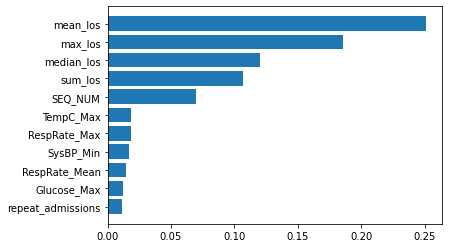

In [273]:
gb_opt = models[-2].fit(X_train_pp, y_train)
feat_indexes_gb = feature_imp(abs(gb_opt.feature_importances_), feature_names)

#the mean length of stay given all the diseases of a certain person is the most important factor
# that determine the LOS of the patient
# In other words, given the diagnosis of the patient, we information on the length of stay that specific diseases incurs
# for example, if you are diagnosed with Diagnosis A, you're only hospitalizaed for 1 day.
# but if you're diagnosed with Diagnosis B, you'll be hospitalized for 10 days.

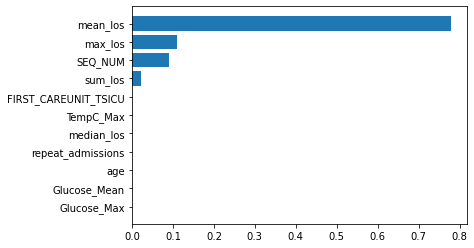

In [274]:
dectree_opt = models[2].fit(X_train_pp, y_train)
feat_indexes_dectree = feature_imp(abs(dectree_opt.feature_importances_), feature_names)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


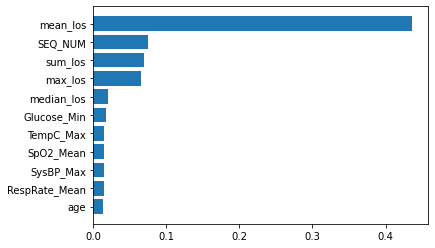

In [275]:
randomforest_opt = models[3].fit(X_train_pp, y_train)
feat_indexes_randomforest = feature_imp(abs(randomforest_opt.feature_importances_), feature_names)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


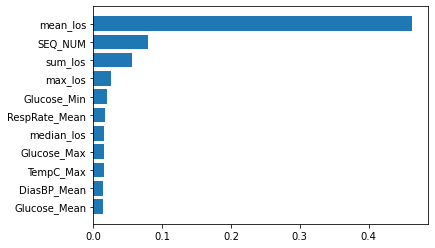

In [276]:
adab_opt = models[4].fit(X_train_pp, y_train)
feat_indexes_adab = feature_imp(abs(adab_opt.feature_importances_), feature_names)

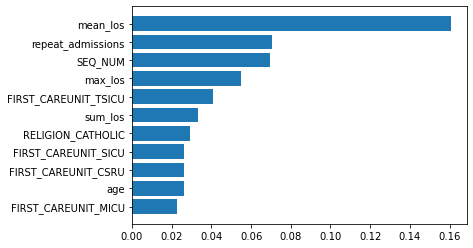

In [277]:
xgb_opt = models[6].fit(X_train_pp, y_train)
feat_indexes_xgb = feature_imp(abs(xgb_opt.feature_importances_), feature_names)

For all models, the mean length of stay (LOS) given all the diseases of a certain person is the most important factor
that determine the LOS of the patient.

## Model Interpretability

### LIME

In local interpretable model-agnostic explanations (LIME), linear models are approximated to interpret black box models. Instead of training a global surrogate model, LIME focuses on training local surrogate models to explain individual predictions.

Source: https://christophm.github.io/interpretable-ml-book/lime.html

In [77]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_pp.values,#must be numpy
    mode='regression',
    training_labels=y_train,
    feature_names=[s for s in X_train_pp.columns.values])
    #feature_names=[s[10:] for s in X_train_pp.columns.values])

In [78]:
models[-1].fit(X_train_pp.values, y_train)

# asking for explanation for the observation with index 1
observation_to_explain = 1 
exp = explainer.explain_instance(# this is important, this is not quite like a 
    data_row = X_train_pp.iloc[observation_to_explain].values,# the observation
    predict_fn = models[-1].predict)# the function to produce predictions

In [79]:
print(y_train.iloc[1])
print(exp.predicted_value)

LOS    0.7582
Name: 1, dtype: float64
0.72768414


In [80]:
exp.show_in_notebook()# shows the prediction interpretation in the notebook environment

#in contrast to expectation that we have with global interpretation, mean LOS actually contributes negatively to thispartcular observation
#having a life partner contributes postively to LOS

# I think we're seeing this seemingly odd local results is because the actually LOS is very low

{0: 3.078190576380327, 1: 3.078190576380327}
0.78610146


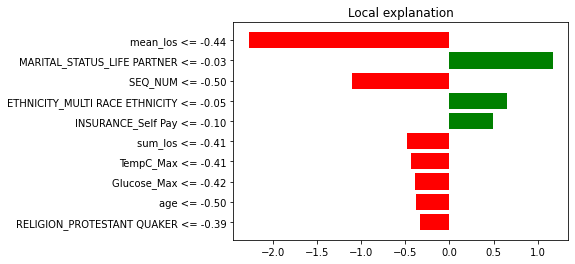

In [80]:
exp.as_pyplot_figure()
print(exp.intercept)
print(exp.predicted_value)

# same as interpretation as above

Trying for another patient.

In [81]:
models[-1].fit(X_train_pp.values, y_train)

# asking for explanation for the observation with index 802
observation_to_explain = 802 
exp = explainer.explain_instance(
    data_row = X_train_pp.iloc[observation_to_explain].values,# the observation
    predict_fn = models[-1].predict)# the function to produce predictions

In [82]:
print(y_train.iloc[802])
print(exp.predicted_value)

LOS    4.4894
Name: 802, dtype: float64
3.7527792


In [83]:
exp.show_in_notebook()# shows the prediction interpretation in the notebook environment

#the number of diseases contributes postively to LOS
# this is in line with expectations because a patient who has more diseases need more treatment in the hospital
# mean LOS given all the diseases of a patient still contributes to the LOS of the patient, although it's negative

{0: 4.3549118072188975, 1: 4.3549118072188975}
3.1773283


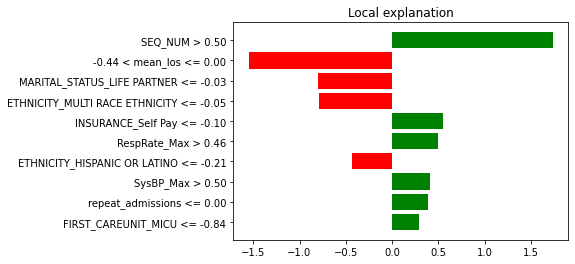

In [84]:
exp.as_pyplot_figure()
print(exp.intercept)
print(exp.predicted_value)

#same interpretation as above

### Shap

We produce global explanations using SHAP.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


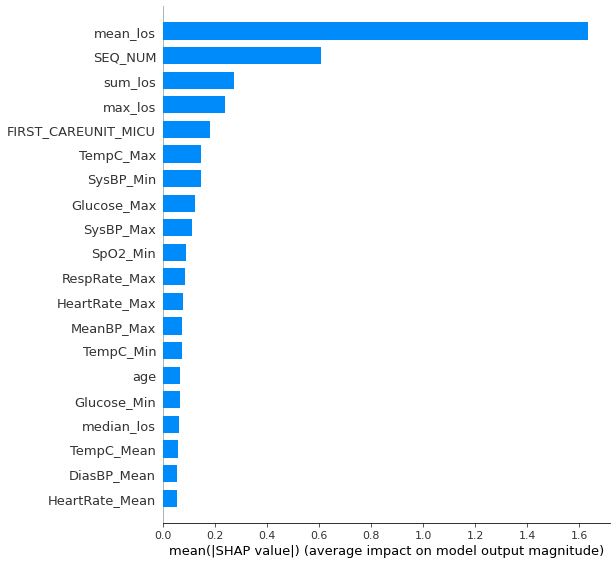

In [86]:
import shap
explainer = shap.TreeExplainer(models[-1]) #(***) gb_model is boosting model 
shap_values = explainer.shap_values(X_train_pp)
shap.initjs()
shap.summary_plot(shap_values, X_train_pp, plot_type="bar")

#mean_los has the greatest impact on the predictions, followed by number of diseases per admission

Let's compare to feature importance from the model. Results have some similarities but still have differences.
For example, the thirdmost important feature according to Shap is sum_los while according to .feature importances, it is repeat admissions.

[Text(0, 0, 'mean_los'),
 Text(1, 0, 'SEQ_NUM'),
 Text(2, 0, 'repeat_admissions'),
 Text(3, 0, 'FIRST_CAREUNIT_TSICU'),
 Text(4, 0, 'sum_los'),
 Text(5, 0, 'max_los'),
 Text(6, 0, 'RELIGION_UNOBTAINABLE'),
 Text(7, 0, 'RELIGION_PROTESTANT QUAKER'),
 Text(8, 0, 'MARITAL_STATUS_WIDOWED'),
 Text(9, 0, 'FIRST_CAREUNIT_CSRU'),
 Text(10, 0, 'FIRST_CAREUNIT_MICU'),
 Text(11, 0, 'FIRST_CAREUNIT_SICU'),
 Text(12, 0, 'DiasBP_Mean'),
 Text(13, 0, 'ETHNICITY_OTHER'),
 Text(14, 0, 'age'),
 Text(15, 0, 'INSURANCE_Private'),
 Text(16, 0, 'ADMISSION_TYPE_ELECTIVE'),
 Text(17, 0, 'MeanBP_Mean'),
 Text(18, 0, 'SpO2_Max'),
 Text(19, 0, 'Glucose_Min'),
 Text(20, 0, 'Glucose_Mean'),
 Text(21, 0, 'SysBP_Mean'),
 Text(22, 0, 'Glucose_Max'),
 Text(23, 0, 'MeanBP_Max'),
 Text(24, 0, 'RespRate_Mean'),
 Text(25, 0, 'SysBP_Min'),
 Text(26, 0, 'SpO2_Min'),
 Text(27, 0, 'TempC_Mean'),
 Text(28, 0, 'SysBP_Max'),
 Text(29, 0, 'TempC_Max'),
 Text(30, 0, 'RELIGION_OTHER'),
 Text(31, 0, 'MARITAL_STATUS_MARRIED'),
 Text(

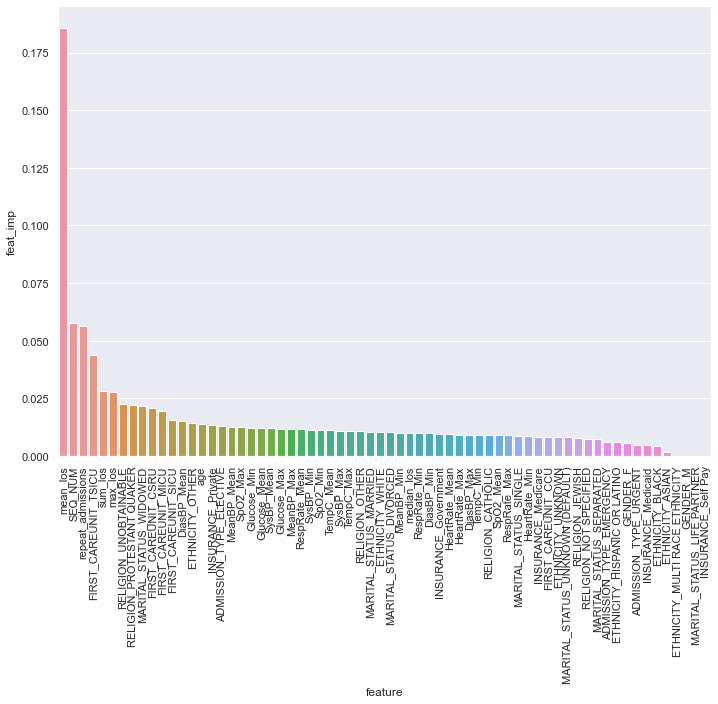

In [88]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

#build dataframe
aux_fimp=pd.DataFrame(zip(X_train_pp.columns, models[-1].feature_importances_), columns=['feature','feat_imp'])
aux_fimp.sort_values(by='feat_imp',ascending=False,inplace=True)
# plot
chart=sns.barplot(x='feature',y='feat_imp',data=aux_fimp)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

### Ensembling, quick implementation

Full implementation of ensembling a separate section.

```
%%time

#added bagging to improve predictions on Random Forest
from sklearn.ensemble import BaggingRegressor
bag = BaggingRegressor(base_estimator=models_6, n_estimators=40)
bag.fit(X_train_pp,np.array(y_train).ravel())
```

```
y_pred_a = bag.predict(X_test_pp)
y_pred_a
```

### Feature Selection

We do feature selection to narrows down the number of variables to those that are likely to be most useful to a model in order to predict the target variable.

I commented this out as it did not improve my predictions.

```
from sklearn.feature_selection import RFE
from sklearn import svm
selector = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=30, verbose=100, step=5)
selector = selector.fit(X_train_pp, y_train)
```

```
selector.ranking_
```

```
selector.support_
```

```
# transform the data
X_train_rfe = selector.transform(X_train_pp)
X_test_rfe = selector.transform(X_test_pp)

print(X_train_rfe.shape)
print(X_test_rfe.shape)
```

```
%%time

#regressor


# models
models_a = [XGBRegressor(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          AdaBoostRegressor(),
         GradientBoostingRegressor()]

# models parameters
xgb_params = {'objective':['reg:squarederror'],
                  'learning_rate': [0.05, 1],
                  'max_depth': range(3, 10),
                  'min_child_weight': range(5, 10),
                  'reg_lambda':[1.5],
                  'seed': [SEED]}

dectree_params = {'max_features': range(4, 10),
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}

randomforest_params = {'max_features': range(4, 10),
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}

adab_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'loss':['linear', 'square'],
                  'random_state': [SEED]}

gb_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                'max_features': range(4, 10),
                  'random_state': [SEED]}

params = [xgb_params, dectree_params, randomforest_params, adab_params, gb_params]
names = ['XGB_Regressor', 'DecisionTree_Regressor', 'RandomForest_Regressor', 'AdaBoost_Regressor',
        'GradientBoosting_Regressor']
scores = {}

# gridsearch
for i, model in enumerate(models_a):
    print(f"Grid-Searching (randomized) for model {names[i]}...")
    best_model = RandomizedSearchCV(model, params[i], n_jobs=4, cv=7, 
                              scoring='neg_mean_squared_error', verbose = 7, n_iter=7)
    best_model.fit(X_train_rfe, y_train)
    print(f"Best model fitted")
    #y_hat_1 = best_model.predict(X_test_1)
    
    #mse = mean_squared_error(y_test_1, y_hat_1)
    #assign the best parameters to my models
    models_a[i].set_params(**best_model.best_params_)
    
    #print scores (on log parcelvalue)
    #scores[names[i]] = (best_model.best_estimator_, mse)
    print(f'{names[i]} chosen hyperparameters: {best_model.best_params_}')
    print(f'{names[i]} MSE score on train sample: {-best_model.best_score_}')
    #print(f'{names[i]} MSE score on test sample: {mse}\n')
```

```
#added bagging to improve predictions

from sklearn.ensemble import BaggingRegressor
bag = BaggingRegressor(base_estimator=models_a[0], n_estimators=20)
bag.fit(X_train_rfe,y_train)
```

```
y_pred_b = bag.predict(X_test_rfe)
y_pred_b
print(y_pred.shape)
```

Note that my model performs better without feature selection.

# Step 7: Applying to test set

Steps applied to training set have been applied to test set immediately afterwards (see previous steps)

# Ensembling

We start use the models from our previous grid search. Ensembling combines our previous simple models (although from the grid search so it has been tuned already) with the following meta learners to make our model more generalizable/improve performance.

In [102]:
%%time
#v2

import time


meta_learners = [
    ExtraTreesRegressor(n_estimators=100, max_features=0.5, random_state=SEED),
    RandomForestRegressor(n_estimators=100, max_features=0.5, random_state=SEED),
    GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, random_state=SEED)
]

meta_learners_ = ['ExtraTrees', 'RandomForest', 'GradientBoosting']

for i, meta_learner in enumerate(meta_learners):
    super_learner = SuperLearner(folds=5, random_state=SEED)

    super_learner.add(models)
    super_learner.add_meta(meta_learner)
    super_learner.fit(X_train_pp, np.array(y_train).ravel())
    #best_model_a.fit(X_train_pp, np.array(y_train).ravel())
    print(f"Best model fitted")

    y_pred_tr = super_learner.predict(X_train_pp)
    mse_tr = mean_squared_error(y_train, y_pred_tr)
    #models[i].set_params(**best_model.best_params_)
    

    
    scores[f'Stacking{meta_learners_[i]}'] = (super_learner, mse_tr)
    print(f'Super Learner with {meta_learners_[i]} MSE on train sample: {mse_tr}')

Best model fitted
Super Learner with ExtraTrees MSE on train sample: 9.849033040847107
Best model fitted
Super Learner with RandomForest MSE on train sample: 8.940659361564114
Best model fitted
Super Learner with GradientBoosting MSE on train sample: 10.228675473914505
Wall time: 21min 48s


```
%%time

#added bagging to improve predictions on Random Forest
from sklearn.ensemble import BaggingRegressor
bag = BaggingRegressor(base_estimator=super_learner, n_estimators=10)
bag.fit(X_train_pp,np.array(y_train).ravel())
```

### with feature propagation

We propagate features to the superlearner, to avoid only having results of previous models.

In [103]:
features_d = column_names

In [104]:
def feature_imp(coef, names):
    imp = coef
    indexes = np.argsort(imp)[-11:]
    indexes = list(indexes)
    
    plt.barh(range(len(indexes)), imp[indexes], align='center')
    plt.yticks(range(len(indexes)), [names[i] for i in indexes])
    plt.show()
    
    return indexes

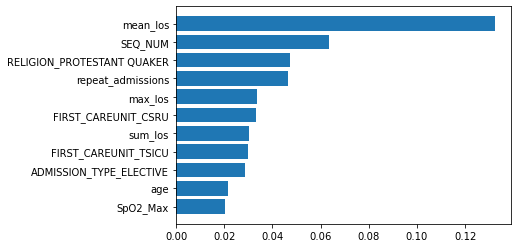

In [105]:
### change the model to gb?

xgb_opt = models[-1].fit(X_train_pp, y_train)
#gb_opt = models[-2].fit(X_train_pp, y_train)
feat_indexes_xgb = feature_imp(abs(xgb_opt.feature_importances_), features_d)
#feat_indexes_gb = feature_imp(abs(gb_opt.feature_importances_), features_d)

#the most important feature is the mean los of the patient given all the diseases the patient has

In [106]:
feat_to_prop = [features_d[i] for i in feat_indexes_xgb][-5:]
pointer = [i for i, feat in enumerate(features_d) if feat in feat_to_prop]
X_train_pp = pd.DataFrame(X_train_pp)
X_train_pp.columns = column_names
X_train_pp.columns[pointer]

Index(['repeat_admissions', 'SEQ_NUM', 'max_los', 'mean_los',
       'RELIGION_PROTESTANT QUAKER'],
      dtype='object')

In [107]:
X_train_pp.head()

HeartRate_Min  HeartRate_Max  HeartRate_Mean  SysBP_Min  SysBP_Max  \
0       1.052632       1.500000        1.763572  -0.761905  -0.700000   
1      -0.315789       0.250000       -0.239733  -0.047619  -0.900000   
2       0.631579      -0.178571        0.360985  -0.095238  -0.333333   
3       0.368421       0.892857        0.703462  -0.285714  -0.433333   
4      -0.578947      -1.392857       -1.137717  -0.571429  -1.000000   

   SysBP_Mean  DiasBP_Min  DiasBP_Max  DiasBP_Mean  MeanBP_Min  ...  \
0   -0.458396   -0.142857    0.173913    -0.015208    0.133333  ...   
1   -0.451852    0.357143   -0.521739     0.239156    0.066667  ...   
2   -0.181260    0.071429   -0.826087    -0.326246    0.466667  ...   
3   -0.441138   -1.000000    0.130435    -1.395075   -0.600000  ...   
4   -0.778435   -1.285714   -1.695652    -1.608312   -1.200000  ...   

   ETHNICITY_HISPANIC OR LATINO  ETHNICITY_MULTI RACE ETHNICITY  \
0                     -0.207109                       -0.048988   
1                     -0.207109                       -0.048988   
2                     -0.207109                       -0.048988   
3                     -0.207109                       -0.048988   
4                     -0.207109                       -0.048988   

   ETHNICITY_OTHER  ETHNICITY_UNKNOWN  ETHNICITY_WHITE  FIRST_CAREUNIT_CCU  \
0         -0.16901          -0.259745         0.601965            -0.36976   
1         -0.16901          -0.259745         0.601965            -0.36976   
2         -0.16901          -0.259745        -1.661227            -0.36976   
3         -0.16901          -0.259745         0.601965            -0.36976   
4         -0.16901          -0.259745         0.601965            -0.36976   

   FIRST_CAREUNIT_CSRU  FIRST_CAREUNIT_MICU  FIRST_CAREUNIT_SICU  \
0             -0.41963             1.190481            -0.483783   
1             -0.41963             1.190481            -0.483783   
2             -0.41963             1.190481            -0.483783   
3             -0.41963            -0.839997             2.067041   
4             -0.41963            -0.839997            -0.483783   

   FIRST_CAREUNIT_TSICU  
0             -0.380803  
1             -0.380803  
2             -0.380803  
3             -0.380803  
4              2.626029  

[5 rows x 66 columns]

We train an entirely new model to learn how to best combine the contributions from each submodel.

In [108]:
%%time

from sklearn.metrics import mean_squared_error

for i, meta_learner in enumerate(meta_learners):
    print(f'\nStackingPropagating {meta_learners_[i]}')
    super_learner = SuperLearner(folds=5, random_state=SEED)

    super_learner.add(models, propagate_features=pointer)
    super_learner.add_meta(meta_learner)
    super_learner.fit(X_train_pp.values, np.array(y_train))
    
    y_pred_tr = super_learner.predict(X_train_pp.values)
    mse_tr = mean_squared_error(np.array(y_train), y_pred_tr)
 
    scores[f'StackingPropagating{meta_learners_[i]}'] = (super_learner, mse_tr)
    
    print(f'Super Learner with {meta_learners_[i]} MSE on train sample: {mse_tr}')


StackingPropagating ExtraTrees


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

Super Learner with ExtraTrees MSE on train sample: 8.97151845011521

StackingPropagating RandomForest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

Super Learner with RandomForest MSE on train sample: 9.073811125135185

StackingPropagating GradientBoosting


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

Super Learner with GradientBoosting MSE on train sample: 10.139401637985323
Wall time: 23min 8s


### Save best model

In [110]:
# look at ranking in terms of MSE
ranking = pd.DataFrame.from_dict(scores, orient='index').reset_index()

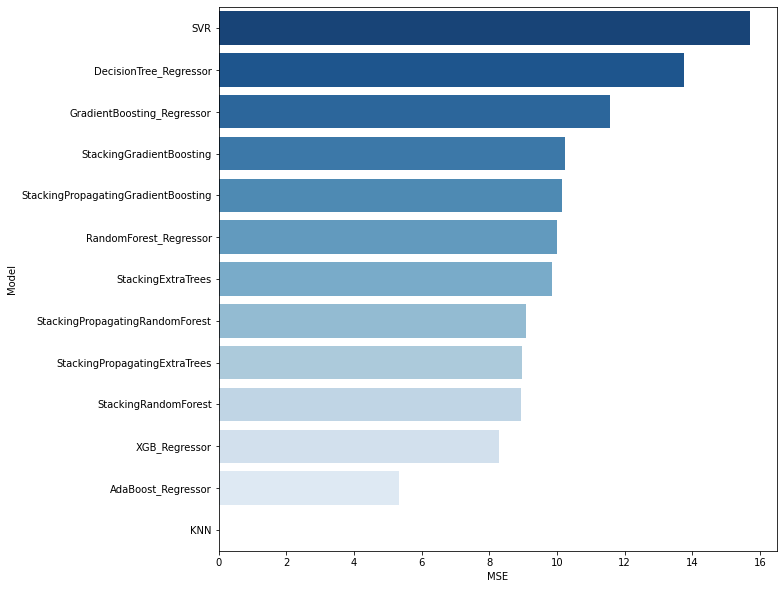

In [111]:
ranking.columns = ['Model', 'Setting', 'MSE']
ranking = ranking.sort_values(by='MSE', ascending=False).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x="MSE", y="Model", data=ranking, ax=ax, palette = 'Blues_r');

#knn overfits

In [298]:
# look at some of the model's performance

best_model_tr = ranking.Setting[11].fit(X_train_pp.values, y_train) #adaboost
y_pred = best_model_tr.predict(X_train_pp.values)

best_model_tr

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=10),
                  learning_rate=0.05, n_estimators=150, random_state=4)

In [299]:
y_pred = best_model_tr.predict(X_test_pp.values)
y_pred

array([2.98303423, 7.70843125, 3.3438472 , ..., 1.84030908, 1.89780236,
       1.49370682])

In [300]:
%%time

#added bagging to improve predictions on Random Forest

bag = BaggingRegressor(base_estimator=best_model_tr, n_estimators=30)
bag.fit(X_train_pp,np.array(y_train).ravel())

Wall time: 40min 3s


BaggingRegressor(base_estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=10),
                                                  learning_rate=0.05,
                                                  n_estimators=150,
                                                  random_state=4),
                 n_estimators=30)

In [301]:
y_pred = bag.predict(X_test_pp)
y_pred

array([2.9938773 , 7.55710707, 3.29806108, ..., 1.88625636, 1.8933855 ,
       1.51906499])

In [302]:
# look at best model's performance

best_model_tr_1 = ranking.Setting[6].fit(X_train_pp.values, y_train) #stackingrandomforest
y_pred_1 = best_model_tr_1.predict(X_train_pp.values)

best_model_tr_1

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

SuperLearner(array_check=None, backend=None, folds=5,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=1146, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=5, raise_on_ex...er=None)],
   n_jobs=-1, name='group-53', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=4, sample_size=20, scorer=None, shuffle=False,
       verbose=False)

In [303]:
y_pred_1 = best_model_tr_1.predict(X_test_pp.values)
y_pred_1

array([3.513684, 9.009315, 3.183224, ..., 1.578485, 2.088083, 1.723692],
      dtype=float32)

In [304]:
%%time

#added bagging to improve predictions on SuperLearner

bag = BaggingRegressor(base_estimator=best_model_tr_1, n_estimators=30)
bag.fit(X_train_pp,np.array(y_train).ravel())

Wall time: 7h 38s


BaggingRegressor(base_estimator=SuperLearner(array_check=None, backend=None, folds=5,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=1146, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=5, raise_on_ex...er=None)],
   n_jobs=-1, name='group-53', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=4, sample_size=20, scorer=None, shuffle=False,
       verbose=False),
                 n_estimators=30)

In [305]:
y_pred_1 = bag.predict(X_test_pp)
y_pred_1

array([ 3.299955 , 10.350123 ,  3.437091 , ...,  1.7888514,  1.9820777,
        1.4536642], dtype=float32)

In [118]:
%%time

## do the same for stacking propagating trees (best ensembling model)

best_model_tr_2 = ranking.Setting[8].fit(X_train_pp.values, y_train) #stackingrandomforest
y_pred = best_model_tr_2.predict(X_test_pp.values)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

Wall time: 6min 41s


In [119]:
bag = BaggingRegressor(base_estimator=best_model_tr_2, n_estimators=30)
bag.fit(X_train_pp,np.array(y_train).ravel())

y_pred = bag.predict(X_test_pp)
y_pred

array([ 3.4281929, 10.408551 ,  3.2652466, ...,  1.7922127,  2.1190765,
        1.4645811], dtype=float32)

<AxesSubplot:ylabel='Density'>

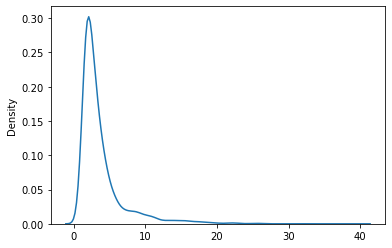

In [120]:
sns.kdeplot(data=y_pred)

# Neural Networks (additional)

Multilayer Perceptrons (MLPs) are comprised of one or more layers of neurons. "Data is fed to the input layer, there may be one or more hidden layers providing levels of abstraction, and predictions are made on the output layer, also called the visible layer."

https://machinelearningmastery.com/when-to-use-mlp-cnn-and-rnn-neural-networks/

In [129]:
#I could install tensorflow so trying to do it manually with pytorch

#importing all the dependencies
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler

#preparing the dataset
X_train_pp_torch = np.array(X_train_pp)
y_train_torch = y_train.values.flatten()

class MyDataset(torch.utils.data.Dataset):
  '''
  Prepare the the dataset for regression
  '''

  def __init__(self, X, y, scale_data=True):
    if not torch.is_tensor(X) and not torch.is_tensor(y):
      # Apply scaling if necessary
      if scale_data:
          X = StandardScaler().fit_transform(X)
      self.X = torch.from_numpy(X)
      self.y = torch.from_numpy(y)

  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return self.X[i], self.y[i]
      

# Creating the neural network. This will be a Multilayer Perceptron based model,      
class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(# Sequential here means that input first flows through the first layer, followed by the second
      nn.Linear(66, 100),
      nn.ReLU(),
      nn.Linear(100, 32),
      nn.ReLU(),
      nn.Linear(32, 1)
    )


  def forward(self, x):
    '''
      Forward pass
    '''
    return self.layers(x)

  
if __name__ == '__main__':
  
  # Set fixed random number seed
  torch.manual_seed(42)
  
  # Load my dataset
  X, y =  X_train_pp_torch, y_train_torch

  # Prepare dataset
  dataset = MyDataset(X, y, scale_data=False)
  #DataLoader ensures that data is shuffled and batched appropriately.
  trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True, num_workers=0) 
  
  # Initialize the MLP
  mlp = MLP()
  
  # Define the loss function and optimizer
  loss_function = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
  
  # Run the training loop
  for epoch in range(0, 20): # 20 epochs at maximum
    
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
      
      # Get and prepare inputs
      inputs, targets = data
      inputs, targets = inputs.float(), targets.float()
      targets = targets.reshape((targets.shape[0], 1))
      print(inputs.shape)
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = loss_function(outputs, targets)
      
      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

  # Process is complete.
  print('Training process has finished.')

#code inspired by https://github.com/christianversloot/machine-learning-articles/blob/main/getting-started-with-pytorch.md

Starting epoch 1
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 66])
torch.Size([10, 6

In [130]:
X = torch.from_numpy(X_train_pp_torch)
y = torch.from_numpy(y_train_torch)
X

tensor([[ 1.0526,  1.5000,  1.7636,  ...,  1.1905, -0.4838, -0.3808],
        [-0.3158,  0.2500, -0.2397,  ...,  1.1905, -0.4838, -0.3808],
        [ 0.6316, -0.1786,  0.3610,  ...,  1.1905, -0.4838, -0.3808],
        ...,
        [-0.5789, -0.2143, -0.3441,  ...,  1.1905, -0.4838, -0.3808],
        [-0.5263, -0.0357, -0.1094,  ..., -0.8400, -0.4838, -0.3808],
        [-0.5263, -0.2143, -0.3158,  ...,  1.1905, -0.4838, -0.3808]],
       dtype=torch.float64)

In [131]:
y_pred = mlp(X.float())
y_pred

tensor([[ 0.0131],
        [ 0.0048],
        [-0.0430],
        ...,
        [-0.0144],
        [-0.0399],
        [-0.0039]], grad_fn=<AddmmBackward0>)

In [132]:
X = torch.from_numpy(np.array(X_test_pp))
y_pred = mlp(X.float())
y_pred = y_pred.cpu().detach().numpy().flatten()
y_pred

array([ 0.04082442, -0.24232672,  0.03447419, ...,  0.02668612,
        0.05909704,  0.09026796], dtype=float32)

<AxesSubplot:ylabel='Density'>

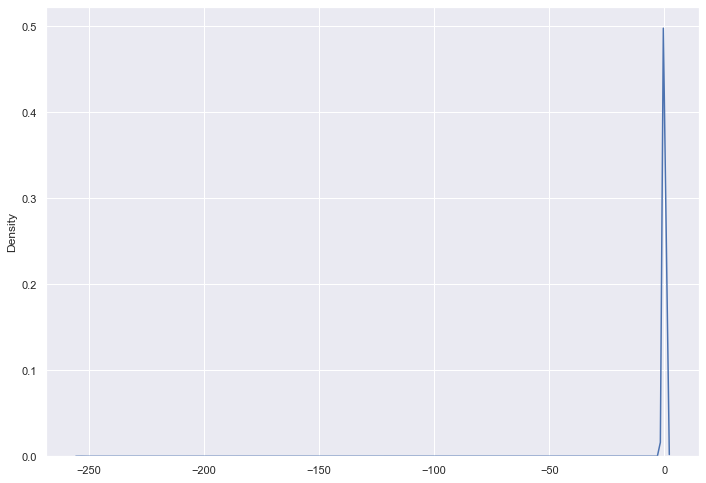

In [133]:
sns.kdeplot(data=y_pred)

#I'm getting weird results

Trying neural networks with the more familiar sklearn

In [134]:
from sklearn.neural_network import MLPRegressor


regr = MLPRegressor(batch_size=100,random_state=1, max_iter=5000, solver='adam').fit(X_train_pp, y_train)
y_pred = regr.predict(X_train_pp)
y_pred
regr.score(X_train_pp, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.744047269031174

In [135]:
y_train

LOS
0       4.5761
1       0.7582
2       3.7626
3       3.8734
4       5.8654
...        ...
20880  11.6116
20881   1.1593
20882   1.8830
20883   3.1981
20884   1.0869

[20885 rows x 1 columns]

In [136]:
y_pred = regr.predict(X_test_pp)
y_pred

array([1.81838488, 4.92849541, 2.1568554 , ..., 2.86960114, 3.11692831,
       2.33693987])

In [137]:
from sklearn.model_selection import cross_validate

estimator=MLPRegressor(batch_size=100, shuffle=True)


param_grid = {#'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,1)],
          'activation': ['relu','tanh','logistic'],
          'alpha': [0.0001, 0.05],
          'learning_rate': ['constant','adaptive'],
          'solver': ['adam']}

gsc = GridSearchCV(
    estimator,
    param_grid,
    cv=5, scoring='neg_mean_squared_error', verbose=30, n_jobs=-1)

grid_result = gsc.fit(X_train_pp, np.array(y_train))


best_params = grid_result.best_params_

best_mlp = MLPRegressor(#hidden_layer_sizes = best_params["hidden_layer_sizes"], 
                        activation =best_params["activation"],
                        solver=best_params["solver"],
                        max_iter= 100000, n_iter_no_change = 400
              )


Fitting 5 folds for each of 12 candidates, totalling 60 fits


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


In [138]:
best_mlp.fit(X_train_pp, y_train)
y_pred = best_mlp.predict(X_test_pp)
print(y_pred.shape)
print(y_pred)

#performed badly in kaggle

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


(5221,)
[ 5.19115427 15.65298319  8.63015922 ...  1.6600691   1.75511232
  2.76528628]


<AxesSubplot:ylabel='Density'>

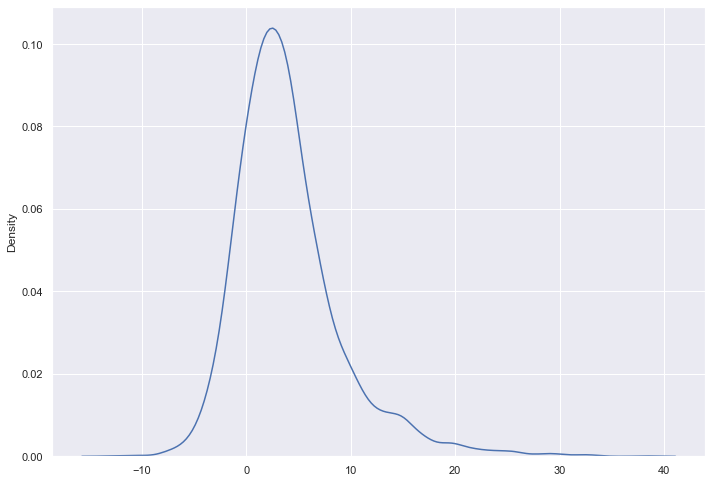

In [139]:
sns.kdeplot(data=y_pred)

#this produces a more sensible result
#but still it performs worse than my trees/boosting/ensembles

# Trying out more new stuff 

### AutoML

In [147]:
#Trying autoML
#!pip3 install auto-sklearn
from autosklearn.regression import AutoSklearnRegressor

# define search
model = AutoSklearnRegressor(time_left_for_this_task=5*60, per_run_time_limit=30, n_jobs=8)
# perform the search
model.fit(X_train_pp, y_train, metric=auto_mean_squared_error)
# summarize
print(model.sprint_statistics())
# evaluate best model
y_hat = model.predict(X_test)
#mae = mean_squared_error(y_test, y_hat)
#print("MSE: %.3f" % mae)

#this failed cause I couldn't install AutoML

    ERROR: Command errored out with exit status 1:
     command: 'C:\ProgramData\Anaconda3\python.exe' -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\sssalas\\AppData\\Local\\Temp\\pip-install-keg_m0pc\\auto-sklearn_178b4a43e6e343e09940770bce1ba085\\setup.py'"'"'; __file__='"'"'C:\\Users\\sssalas\\AppData\\Local\\Temp\\pip-install-keg_m0pc\\auto-sklearn_178b4a43e6e343e09940770bce1ba085\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users\sssalas\AppData\Local\Temp\pip-pip-egg-info-ytalj4m4'
         cwd: C:\Users\sssalas\AppData\Local\Temp\pip-install-keg_m0pc\auto-sklearn_178b4a43e6e343e09940770bce1ba085\
    Complete output (5 lines):
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "C:\Users\sssalas\AppData\Local\Temp\pip-install-keg_m0pc\auto-sklearn_178b4a43e6e343e09

  Using cached auto-sklearn-0.14.6.tar.gz (6.4 MB)
  Using cached auto-sklearn-0.14.5.tar.gz (6.4 MB)
  Using cached auto-sklearn-0.14.4.tar.gz (6.4 MB)
  Using cached auto-sklearn-0.14.3.tar.gz (6.3 MB)
  Using cached auto-sklearn-0.14.2.tar.gz (6.3 MB)
  Using cached auto-sklearn-0.14.1.tar.gz (6.3 MB)
  Using cached auto-sklearn-0.14.0.tar.gz (6.3 MB)
  Using cached auto-sklearn-0.13.0.tar.gz (6.3 MB)
  Using cached auto-sklearn-0.12.7.tar.gz (6.3 MB)
  Using cached auto-sklearn-0.12.6.tar.gz (6.1 MB)
  Using cached auto-sklearn-0.12.5.tar.gz (6.1 MB)
  Using cached auto-sklearn-0.12.4.tar.gz (6.1 MB)
  Using cached auto-sklearn-0.12.3.tar.gz (6.1 MB)
  Using cached auto-sklearn-0.12.2.tar.gz (6.1 MB)
  Using cached auto-sklearn-0.12.1.tar.gz (6.1 MB)
  Using cached auto-sklearn-0.12.0.tar.gz (4.1 MB)
  Using cached auto-sklearn-0.11.1.tar.gz (3.9 MB)
  Using cached auto-sklearn-0.11.0.tar.gz (3.9 MB)
  Using cached auto-sklearn-0.10.0.tar.gz (4.1 MB)
  Using cached auto-sklearn-0.9

ModuleNotFoundError: No module named 'autosklearn'

  copying autosklearn\metalearning\files\recall_micro_binary.classification_sparse\feature_values.arff -> build\lib.win-amd64-3.8\autosklearn\metalearning\files\recall_micro_binary.classification_sparse
  copying autosklearn\metalearning\files\recall_micro_binary.classification_sparse\readme.txt -> build\lib.win-amd64-3.8\autosklearn\metalearning\files\recall_micro_binary.classification_sparse
  creating build\lib.win-amd64-3.8\autosklearn\metalearning\files\recall_micro_multiclass.classification_dense
  copying autosklearn\metalearning\files\recall_micro_multiclass.classification_dense\algorithm_runs.arff -> build\lib.win-amd64-3.8\autosklearn\metalearning\files\recall_micro_multiclass.classification_dense
  copying autosklearn\metalearning\files\recall_micro_multiclass.classification_dense\configurations.csv -> build\lib.win-amd64-3.8\autosklearn\metalearning\files\recall_micro_multiclass.classification_dense
  copying autosklearn\metalearning\files\recall_micro_multiclass.classifica

### Stacking Regressor from sklearn (not manual)

"Stacked generalization consists in stacking the output of individual estimator and use a regressor to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator." - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html#sklearn.ensemble.StackingRegressor


In [152]:

from sklearn.linear_model import RidgeCVfrom sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
X, y = X_train_pp, np.array(y_train)
estimators = [
     ('lr', RidgeCV()),
     ('svr', LinearSVR(random_state=42, C=1, max_iter=10000))
 ]
reg = StackingRegressor(
     estimators=estimators,
     final_estimator=RandomForestRegressor(n_estimators=100,
                                           random_state=42)
 )

#no grid search

reg.fit(X, y)
y_pred = reg.predict(X_test_pp)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


<AxesSubplot:ylabel='Density'>

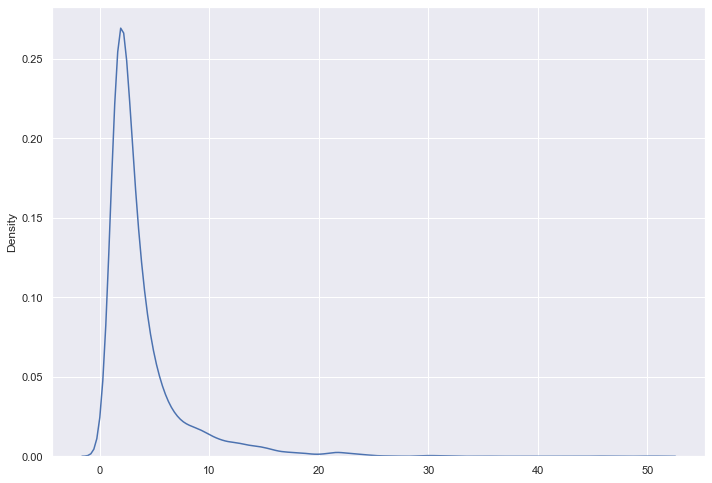

In [153]:
sns.kdeplot(data=y_pred)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

<AxesSubplot:ylabel='Density'>

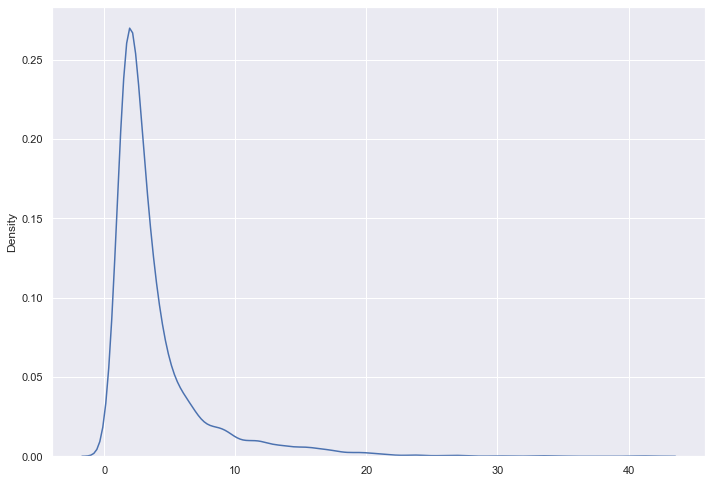

In [170]:
#with grid search

estimators = [
     ('lr', RidgeCV()),
     ('svr', LinearSVR(random_state=42, C=1, max_iter=100000))
 ]
reg = StackingRegressor(
     estimators=estimators,
     final_estimator=RandomForestRegressor(n_estimators=100,
                                           random_state=42)
 )

params = {'svr__C': [0.001, 0.01, 0.5 ,1,2,5]
         } # model1__SOME_PARAM  


grid = GridSearchCV(estimator=reg, param_grid=params, cv=7)
grid.fit(X, y)
    
y_pred = grid.predict(X_test_pp)
    
sns.kdeplot(data=y_pred)

In [172]:
print(grid.best_estimator_)

StackingRegressor(estimators=[('lr', RidgeCV(alphas=array([ 0.1,  1. , 10. ]))),
                              ('svr',
                               LinearSVR(C=5, max_iter=100000,
                                         random_state=42))],
                  final_estimator=RandomForestRegressor(random_state=42))


### Voting Regressor

"The idea behind the VotingRegressor is to combine conceptually different machine learning regressors and return the average predicted values. Such a regressor can be useful for a set of equally well performing models in order to balance out their individual weaknesses."

The VotingRegressor can also be used together with GridSearchCV in order to tune the hyperparameters of the individual estimators but I have already done a previous grid search so I am just reusing my tune paramaters here.



https://scikit-learn.org/stable/modules/ensemble.html

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


<AxesSubplot:ylabel='Density'>

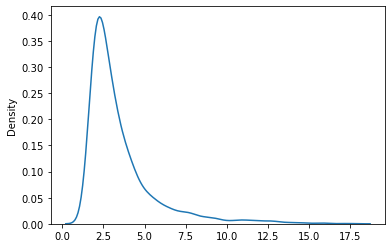

In [74]:
from sklearn.ensemble import VotingRegressor

# Training classifiers
reg1 = models_a[-2] #GradientBoostingRegressor
reg2 = models_a[1] #KNNRegressor
reg3 = models_a[3] #RandomForestRegressor
ereg = VotingRegressor(estimators=[('gb', reg1), ('knn', reg2), ('rf', reg3)])
ereg = ereg.fit(X_train_pp, np.array(y_train))        
y_pred = ereg.predict(X_test_pp)
                
sns.kdeplot(data=y_pred)      

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


<AxesSubplot:ylabel='Density'>

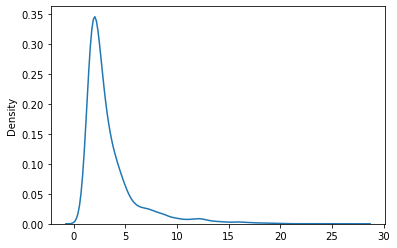

In [84]:
#with more models

# Training classifiers
reg1 = models[-2] #GradientBoostingRegressor
reg2 = models[1] #KNNRegressor
reg3 = models[3] #RandomForestRegressor
reg4 = models[0] #SVR
reg5 = models[2] #Decision Tree
reg6 = models_a[-1] #XGBoost
ereg = VotingRegressor(estimators=[('gb', reg1), ('knn', reg2), ('rf', reg3), ('svr', reg4), ('dt', reg5), ('xgb', reg6)])
ereg = ereg.fit(X_train_pp, np.array(y_train))        
y_pred = ereg.predict(X_test_pp)
                
sns.kdeplot(data=y_pred)

# Step 9: Produce .csv for kaggle testing 

In [121]:
test_predictions_submit = pd.DataFrame({"icustay_id": df_test_orig['icustay_id'], "LOS":y_pred})
test_predictions_submit.to_csv("test_LogReg_predictions_submit_34.csv", index = False)

In [307]:
test_predictions_submit = pd.DataFrame({"icustay_id": df_test_orig['icustay_id'], "LOS":y_pred_1})
test_predictions_submit.to_csv("test_LogReg_predictions_submit_24.csv", index = False)

In [ ]:
#note: submit this test_LogReg_predictions_submit_12... maxed out daily

In [ ]:
test_predictions_submit = pd.DataFrame({"icustay_id": df_test_orig['icustay_id'], "HOSPITAL_EXPIRE_FLAG":y_pred_proba})
test_predictions_submit.to_csv("test_LogReg_predictions_submit_svm_10.csv", index = False)